In [925]:
# Notebook for inspecting KVQA results and explanations
# Load dependencies and data
import cv2
import json
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

from PIL import Image
import pandas as pd
import torchvision.transforms as transforms

from src.lxrt.tokenization import BertTokenizer
lxmert_tokenizer = BertTokenizer.from_pretrained( "bert-base-uncased", do_lower_case=True)

abs_path = "/home/diego/adv_comp_viz21/lxmert/orig_code/lxmert/"

#oracle_spans_dict = json.load(open(abs_path + "data/kvqa/new_kvqa_q_caps_ents0502.json"))
oracle_spans_dict = json.load(open(abs_path + "data/kvqa/kvqa_oracle_ent_spans_with_wikis0923.json"))
sep13_spans_dict = json.load(open(abs_path + "data/kvqa/kvqa_ent_spans_sept13_3corb.json"))  
sep13_few_spans_dict = json.load(open(abs_path + "data/kvqa/kvqa_ent_spans_sept13_fewkbcor.json"))
yasu2_spans_dict = json.load(open(abs_path + "data/kvqa/kvqa_ent_spans_yasu2_0916.json"))

imgid2dims = pd.read_csv("/data/diego/adv_comp_viz21/imgfeat/kvqa_imgs_obj36_meta.tsv", delimiter="\t", names=["img_id","img_w","img_h","features"])

with open("/data/diego/adv_comp_viz21/kvqa_dataset_with_entity_info_and_ref_imgs_v6cum.json","r") as f:
    kvqa_qs = json.load(f)

img2groundents = {k:kvqa_qs[k]['NamedEntities'] for k in kvqa_qs}

In [843]:
#HELPER FUNCTIONS

KVQA_VAL_PATH = '/data/diego/adv_comp_viz21/KVQAimgs/'
def get_image_path(img_id):
    image_file_path = KVQA_VAL_PATH + img_id + '.jpg'
    if not os.path.exists(image_file_path):
        exts = ['.JPG', '.JPEG', '.png', '.PNG', '.jpeg']
        for e in exts:
            image_file_path = KVQA_VAL_PATH + img_id + e
            if os.path.exists(image_file_path):
                break
    return image_file_path

def get_image_expl_vis(image_file_path, bbox_scores, bboxes, orig_img_dims):    
    orig_w = orig_img_dims.img_w.values[0]
    orig_h = orig_img_dims.img_h.values[0]
    bbox_scores = torch.tensor(bbox_scores)
    
    _, top_bboxes_indices = bbox_scores.topk(k=1, dim=-1)
    img = cv2.imread(image_file_path)
    mask = torch.zeros(img.shape[0], img.shape[1])
    #print(img.shape[0], img.shape[1])
    for index in range(len(bbox_scores)):
        [x, y, w, h] = bboxes[index]   
        x *= orig_w
        y *= orig_h
        w *= orig_w
        h *= orig_h
        
        #needed to save out bboxes as well! 
        #and rescale since they were normalized before being saved
        #print("Box",index,x,y,w,h)
        curr_score_tensor = mask[int(y):int(h), int(x):int(w)]     
        new_score_tensor = torch.ones_like(curr_score_tensor)*bbox_scores[index].item()
        mask[int(y):int(h), int(x):int(w)] = torch.max(new_score_tensor,mask[int(y):int(h), int(x):int(w)])
        
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = mask.unsqueeze_(-1)
    mask = mask.expand(img.shape)
    img = img * mask.cpu().data.numpy()
    cv2.imwrite('new.jpg', img)
    masked_image = Image.open('new.jpg')
    return masked_image


def compare_results(df, model1_str, model2_str, metric="top5acc", subset_ents=True, print_out=False):
    # Get rows comparing model1_str and model2_str and they have ent_sets
    if subset_ents == True:
        #by default only show rows that have ent_sets
        k2_rows = df[(df.model == model1_str) & (df.num_ents >0)]
        plain_rows = df[(df.model == model2_str)&(df.qid.isin(k2_rows.qid.values))]
    elif subset_ents == False:
        #this gets all rows without ent sent
        k2_rows = df[(df.model == model1_str) & (df.num_ents == 0) ]
        plain_rows = df[(df.model == model2_str)&(df.qid.isin(k2_rows.qid.values))]
    else:
        #this gets all rows ( with or without ent sent)
        k2_rows = df[(df.model == model1_str)]
        plain_rows = df[(df.model == model2_str)]
        
    k2_rows_gt, k2_rows_eq, k2_rows_lt = [],[],[]
    for c, i in enumerate(plain_rows.index):

        k2 = k2_rows.loc[k2_rows.index[c]]
        pl = plain_rows.loc[i]
        if k2[metric] > pl[metric]:
            k2_rows_gt.append(k2['qid'])
        elif k2[metric] == pl[metric]:
            k2_rows_eq.append(k2['qid'])
        else:
            k2_rows_lt.append(k2['qid'])
       
    if print_out:
        print("\n"+model1_str,">", model2_str, len(k2_rows_gt), round(len(k2_rows_gt)/plain_rows.shape[0],4), "***" if len(k2_rows_gt) > len(k2_rows_lt) else "")
        print(model1_str,"=", model2_str, len(k2_rows_eq), round(len(k2_rows_eq)/plain_rows.shape[0],4))
        print(model1_str,"<", model2_str, len(k2_rows_lt), round(len(k2_rows_lt)/plain_rows.shape[0],4), "***" if len(k2_rows_gt) < len(k2_rows_lt) else "")
    return k2_rows_gt, k2_rows_eq, k2_rows_lt



 
def show_kvqa_bimodal_expls_img(qid, df, okfigsize = (28,7), print_txt=False):        #(20,5)
    mods = ['CAPT', 'EBERT-sep13', 'EBERT-sep13_few', 'EBERT-oracle', "Yasu2"]
    img_id = qid.split("_")[0]
    image_file_path = get_image_path(img_id)
    orig_img_dims = imgid2dims[imgid2dims.img_id == int(img_id)] 
    
    orig_image = Image.open(image_file_path)
    fig, axs = plt.subplots(ncols=6, figsize=okfigsize)  #now needs to be 6 if we use Yasu2 <-- compare this to EBERT-sep13
    axs[0].imshow(orig_image); 
    axs[0].axis('off');
    
    plain = df[(df.qid == str(qid)) &(df.model == 'CAPT')]
    
    if len(plain['tokens'].values[0]) == 1:
        toks = plain['tokens'].values[0][0]
    else:
        toks = plain['tokens'].values[0]
    
    curt = 0
    tmptoks = []
    while curt < len(toks) > 8:
        tmptoks = tmptoks + toks[curt:curt+8] + ["\n"] 
        curt += 8
    ques = " ".join(tmptoks)
    ans = plain['true_ans'].values[0]

    groundents = img2groundents[img_id]
    cur = 0
    titl = ""
    while cur < len(groundents):                
        titl += groundents[cur]+"\n"
        cur += 1
    
    axs[0].set_title(str(qid)+"\nQ:"+ques+"\nA:"+ans+"\n\nGroundEnts:"+titl);
    
             
    for i, v in enumerate(mods):
        plain = df[(df.qid == str(qid)) &(df.model == v)]
        pl_image_expl, pl_bboxes = plain['image_expl'].values[0], plain['bboxes'].values[0]
        masked_image = get_image_expl_vis(image_file_path, pl_image_expl, pl_bboxes, orig_img_dims)
        axs[i+1].imshow(masked_image);
        axs[i+1].axis('off');
        titl = v+': '+plain['top5preds'].values[0][0] +' = '+str(round(plain['top1acc'].values[0],2)) 
        titl += ' ' +str(round(plain['top5acc'].values[0],2))+"\nprobs:"
        titl += str([ round(pr,2) for pr in plain['top5probs'].values[0][0:3]])
        titl += "\nPreds:"+str(plain['top5preds'].values[0][0:2]) + "\n"+str(plain['top5preds'].values[0][2:4])

        if len(plain['tokens'].values[0]) == 1:
            toks = plain['tokens'].values[0][0]
        else:
            toks = plain['tokens'].values[0]
            
        toks = ['CLS'] + toks + ['SEP']
        txt_exps = list(plain['text_expl'].values)
        #print("Toks", toks, txt_exps[0], len(toks) == len(txt_exps[0]))

        text_attrs = [ (toks[a],b) for a, b in enumerate(txt_exps[0]) ] 
        text_attrs_sorted = sorted(text_attrs, key=lambda pair: pair[1], reverse=True)
        titl += "\nToks:"+str(text_attrs_sorted[0]) 
        for ind in range(1,5):
            titl += "\n"+str(text_attrs_sorted[ind]) 
            
        if plain['num_ents'].values[0] > 0:
            titl += "\n**Ent set:"  + str([ et[0] for et in plain['ent_set'].values[0][0:1]])
            cur = 1
            while cur < plain['num_ents'].values[0]:                
                titl += "\n"+str([ et[0] for et in plain['ent_set'].values[0][cur:cur+1 ]])
                cur += 1
                
        axs[i+1].set_title(titl);
    
    if print_txt:
        print("QID:",qid,"\nTRUE ANSWER:", plain['true_ans'])
        print("Question:"," ".join(plain['tokens'].values[0][0])) 

def show_items_for_eval(df, comp_str="4K vs Plain", with_ents=True,  cmp_type="gt", toshow = 50):
    #comps = ["2.5K vs Plain", "2.5K vs 13K", "2.5K vs 4K", "4K vs 13K", "4K vs Plain", "13K vs Plain"]
    comps = ["EBERT-oracle vs CAPT" , "EBERT-sep13 vs CAPT", "EBERT-sep13_few vs CAPT", "Yasu2 vs CAPT"]

    gt_eq_lt_map = ["gt", "eq", "lt"]
    if comp_str not in comps:
        print("ERROR: must select comp_str from", comps)
        return []
    elif cmp_type not in gt_eq_lt_map:
        print("Comparision type must be in ", gt_eq_lt_map)
        return []
    else:
        ind = comps.index(comp_str)
        cind = gt_eq_lt_map.index(cmp_type)
        if with_ents:
            exs = res_set1[ind]
        else:
            exs = res_set1_wo[ind]
            
    ent_type = "with ent spans" if with_ents else "with out ent spans"
    tot = len(exs[0]) + len(exs[1]) + len(exs[2])
    print("Looking at",comp_str," for questions ", ent_type, tot, "out of 5046", round(tot/5046,4))
    m1 = comp_str.split("vs")[0]
    m2 = comp_str.split("vs")[1]
    print(m1+"better than "+m2,":", len(exs[0]),  round(len(exs[0])/5046,4),
          "\n"+m1+"worse than",m2,":",len(exs[2]),round(len(exs[2])/5046,4),
          "\n"+m1+"and equal to ",m2,":", len(exs[1]), round(len(exs[1])/5046,4))   

    ents = np.random.choice(exs[cind],toshow,replace=False)
    cmp_label = ["BETTER THAN",  "EQUAL TO", "WORSE THAN" ]
    print("\nSHOWING ",toshow," RANDOM QUESTIONS "+ent_type.upper()+" WHERE "+m1+cmp_label[cind]+ m2)
    print("out of possible", len(exs[cind]))

    qids = []
    for i, qid in enumerate(ents):     
        qids.append(qid)
        show_kvqa_bimodal_expls_img(qid, df, okfigsize=(25,5))

    print(qids)
    return qids



In [844]:
""" SCRATCH OLD RECORDS
import time
split = 0
def get_kvqa_perturb_records(split=0):
    # TODO: run perturb for sep13_3 and sep13_few for 1 - 4
    print("Getting Explanation records for KVQA Split:", split)
    st = time.time()
    if split == 0:                                                                     #   top1   top5  t1raw t5raw  total
        plain_records = json.load(open("experiments/kvqa_plain_0_newlxmo_0905.json"))  # [47.27, 66.71, 8838, 12473, 18697]
        capt_records = json.load(open("experiments/kvqa_capt_0_newlxmo_0905.json"))    # [49.84, 67.66, 9318, 12650, 18697]
        ebert_records =  json.load(open("experiments/kvqa_ebert_0_newlxmo_0905.json")) # [51.66, 69.10, 9659, 12919, 18697]
        ebert_sep13_3 = json.load(open("experiments/kvqa_ebert_0_sep13_3.json"))       # [49.97, 67.21, 9343, 12567, 18697]
        ebert_sep13_few = json.load(open("experiments/kvqa_ebert_0_sep13_fewkb.json")) # [50.05, 67.56, 9358, 12631, 18697]
    if split == 1:                          
        plain_records = json.load(open("experiments/kvqa_plain_1_newlxmo_0905.json"))  # [47.54, 67.27, 8797, 12448, 18505]
        capt_records = json.load(open("experiments/kvqa_capt_1_newlxmo_0905.json"))    # [50.43, 68.28, 9332, 12636, 18505]
        ebert_records =  json.load(open("experiments/kvqa_ebert_1_newlxmo_0905.json")) # [52.20, 69.20, 9660, 12805, 18505]
        ebert_sep13_3 = json.load(open("experiments/kvqa_ebert_1_sep13_3.json"))       # [50.33, 67.49, 9313, 12489, 18505]
        ebert_sep13_few = json.load(open("experiments/kvqa_ebert_1_sep13_fewkb.json")) # [50.42, 67.75, 9330, 12537, 18505]
    if split == 2:                                   
        plain_records = json.load(open("experiments/kvqa_plain_2_newlxmo_0905.json"))  # [47.35, 67.16, 8853, 12556, 18696]
        capt_records = json.load(open("experiments/kvqa_capt_2_newlxmo_0905.json"))    # [50.66, 68.06, 9471, 12725, 18696]
        ebert_records =  json.load(open("experiments/kvqa_ebert_2_newlxmo_0905.json")) # [52.12, 69.20, 9745, 12937, 18696]
        ebert_sep13_3 = json.load(open("experiments/kvqa_ebert_2_sep13_3.json"))       # [50.29, 67.24, 9403, 12571, 18696]
        ebert_sep13_few = json.load(open("experiments/kvqa_ebert_2_sep13_fewkb.json")) # [50.34, 67.13, 9411, 12550, 18696]
    if split == 3:
        plain_records = json.load(open("experiments/kvqa_plain_3_newlxmo_0901.json"))  # [48.35, 67.37, 9306, 12968, 19248]
        capt_records = json.load(open("experiments/kvqa_capt_3_newlxmo_0901.json"))    # [51.05, 68.04, 9827, 13097, 19248]
        ebert_records =  json.load(open("experiments/kvqa_ebert_3_newlxmo_0901.json")) # [53.18, 69.42, 10236, 13361, 19248]
        ebert_sep13_3 = json.load(open("experiments/kvqa_ebert_3_sep13_3.json"))       # [51.47, 68.34, 9907, 13155, 19248]
        ebert_sep13_few = json.load(open("experiments/kvqa_ebert_3_sep13_fewkb.json")) # [51.27, 67.59, 9869, 13009, 19248]
    if split == 4:
        plain_records = json.load(open("experiments/kvqa_plain_4_newlxmo_0905.json"))  # [47.18, 67.04, 8549, 12148, 18120]
        capt_records = json.load(open("experiments/kvqa_capt_4_newlxmo_0905.json"))    # [49.25, 67.36, 8925, 12205, 18120]
        ebert_records =  json.load(open("experiments/kvqa_ebert_4_newlxmo_0905.json")) # [52.15, 68.82, 9449, 12471, 18120]
        ebert_sep13_3 = json.load(open("experiments/kvqa_ebert_3_sep13_4.json"))       # [50.43, 67.68, 9138, 12263, 18120]
        ebert_sep13_few = json.load(open("experiments/kvqa_ebert_4_sep13_fewkb.json")) # [49.75, 67.22, 9014, 12181, 18120]
    if split == "all":
        sp0 = get_kvqa_perturb_records(split=0)
        sp1 = get_kvqa_perturb_records(split=1)
        sp2 = get_kvqa_perturb_records(split=2)
        sp3 = get_kvqa_perturb_records(split=3)
        sp4 = get_kvqa_perturb_records(split=4)
        plain_records, capt_records, ebert_records, ebert_sep13_3, ebert_sep13_few = sp0
        for recs in [sp1, sp2, sp3, sp4]:
            pr, cr, er, es3, esfew = recs
            plain_records.update(pr) 
            capt_records.update(cr) 
            ebert_records.update(er) 
            ebert_sep13_3.update(es3) 
            ebert_sep13_few.update(esfew)
    print("Elapsed.", time.time() - st)
    return plain_records, capt_records, ebert_records, ebert_sep13_3, ebert_sep13_few

#############################################
#############################################
#############################################
########################   SUPER IMPORTANT          SET SPLIT NUMBER HERE
#############################################
#############################################
#############################################

"""
print()

import time
split = 0
def get_kvqa_perturb_records(split=0):
    # TODO: run perturb for sep13_3 and sep13_few for 1 - 4
    p = "../lxmert_gen/Transformer-MM-Explainability-main/"
    print("Getting Explanation records for KVQA Split:", split)
    st = time.time()
    if split == 0:                                                                             #   top1   top5    qs   ent coverage
        plain_r = json.load(open(p+"experiments/kvqa_plain_0_newlxmo_0905.json"))              # [47.27, 66.71, 18697,     0  ]
        capt_r = json.load(open(p+"experiments/kvqa_capt_0_newlxmo_0905.json"))                # [49.84, 67.66, 18697,     0  ]       
        eb_sep13_3 = json.load(open(p+"experiments/kvqa_ebert_0_sept13_3_val19_f.json"))       # [49.56, 67.65, 18697,    98.1]
        eb_sep13_few = json.load(open(p+"experiments/kvqa_ebert_0_sept13_fewkb_val19_f.json")) # [50.08, 67.66, 18697,    95.85] 
        yasu2_records = json.load(open(p+"experiments/kvqa_ebert_0_yasu2_val19_f.json"))       # [49.77, 67.58, 18697,     .. ]
        # these two ebert_rs use the NONE oracle entset
        #ebert_r =  json.load(open(p+"experiments/kvqa_ebert_0_oracle_val19_f.json"))          # [51.97, 68.75, 18697,    100]
        #ebert_r =  json.load(open(p+"experiments/kvqa_ebert_0_oracle_val19_fixed.json"))      # [52.2 , 68.89, 18697]   <-- post fix in kvqa_perturb
        ebert_r = json.load(open(p+"experiments/kvqa_ebert_0_oracle_links_val23.json"))        # [52.83, 69.6,  18697] 
        return plain_r, capt_r, ebert_r, eb_sep13_3, eb_sep13_few, yasu2_records
    else:
        print(split, " not supported at the moment ")
  
split = 0
plain_records, capt_records, ebert_records, ebert_sep13_3, ebert_sep13_few, yasu2 = get_kvqa_perturb_records(split)


Getting Explanation records for KVQA Split: 0


In [845]:
# GENERATE pandas to use for differentiating results for a given split
tokenize = False 
toshow = 2
pd_rows = []
for ind, k in enumerate(plain_records):
    imgid = k.split("_")[0]
    q = int(k.split("_")[1])
    cur_dict = {'Plain':plain_records[k], 'CAPT':capt_records[k], 'EBERT-oracle':ebert_records[k],
               'EBERT-sep13': ebert_sep13_3[k], 'EBERT-sep13_few': ebert_sep13_few[k], 'Yasu2': yasu2[k]}
    
    cur_ents = {'Plain':[], 'CAPT':[], 'EBERT-oracle':oracle_spans_dict[imgid]["ents_found"],
               'EBERT-sep13':sep13_spans_dict[imgid]["ents_found"],
               'EBERT-sep13_few':sep13_few_spans_dict[imgid]["ents_found"],
               'Yasu2': yasu2_spans_dict[imgid]["ents_found"]}

    true_ans = plain_records[k]['true_ans']
    capt = kvqa_qs[imgid]['wikiCap']
    oracle_capt = oracle_spans_dict[imgid]['wikiCap_new']
    sent = kvqa_qs[imgid]['Questions'][q]
    if ind < toshow:
        print("\n"+k, sent,'\ntrue_ans', true_ans )    #true ans is incorrectly saved so use from questions directly    

    # perturbation_okvqa.py now passes in "tokens" in records 
    # whereas here we don't have it have it for Plain, CAPT or EBERT-oracle
    # so we need to either re-run those threes perturb_kvqa or load tokenizer to do it
    
    for i in cur_dict:
        v = cur_dict[i]
            
        if "tokens" not in v:
            tokens = []            
            if i == "Plain":
                tokens = lxmert_tokenizer.tokenize(sent)                     
            elif i in ["CAPT"]:
                tokens = lxmert_tokenizer.tokenize(sent+" " + capt)
            elif i in ["EBERT-oracle", 'EBERT-sep13', 'EBERT-sep13_few', 'Yasu2']:  #wrong <--- FIX THIS to use APPROPRIATE ent spans !
                print(i)
                tokens = lxmert_tokenizer.tokenize(sent+" " + oracle_capt)
        else:
            tokens = v["tokens"]            
         
        #add ent_sets and explanations as well here
        try:
            if ind < toshow:
                print(i, "\t", round(v['top1acc'],3), "\t", v['top5'], [round(b,3) for b in v['top5probs']], "\t", v['top5acc'] )
            
            pd_rows.append([k,ind, i, round(v['top1acc'],3), v['top5acc'], v['top5'],[round(b,3) for b in v['top5probs']],
                            true_ans, len(cur_ents[i]), cur_ents[i], v['text_expl'], tokens, v['image_expl'], v['bboxes']])
        except Exception as e:
            print(k,ind,i,v,e)
            import sys
            sys.exit()
                  
df = pd.DataFrame(pd_rows, columns=["qid","val_ind","model","top1acc","top5acc","top5preds","top5probs","true_ans",
                                    "num_ents","ent_set","text_expl","tokens","image_expl","bboxes"]) 


22511_0 Who is the person in the image? 
true_ans Henry Labouchère
Plain 	 0 	 ['Paul Kruger', 'Yes', 'Abraham Lincoln', 'No', 'John C. Breckinridge'] [-5.373, -5.563, -5.804, -5.951, -5.995] 	 0
CAPT 	 0 	 ['Yes', 'No', 'Paul Kruger', 'Europe', '2'] [-5.382, -5.44, -5.573, -6.022, -6.17] 	 0
EBERT-oracle 	 0 	 ['Charles Tupper', 'Jacob Dolson Cox', 'Bonar Law', 'Alfred Deakin', 'Robert T. Van Horn'] [-5.28, -5.85, -5.904, -5.99, -6.019] 	 0
EBERT-sep13 	 0 	 ['No', 'Paul Kruger', 'Yes', 'Otto von Bismarck', 'Napoleon III'] [-5.343, -5.649, -5.664, -5.953, -6.195] 	 0
EBERT-sep13_few 	 0 	 ['Paul Kruger', 'No', 'H. H. Asquith', 'Yes', 'Alfred Deakin'] [-5.138, -5.614, -6.003, -6.032, -6.058] 	 0
Yasu2 	 0 	 ['Paul Kruger', 'John C. Breckinridge', 'H. H. Asquith', 'Alfred Deakin', 'Jacob Dolson Cox'] [-5.898, -6.081, -6.139, -6.223, -6.232] 	 0

22511_1 For how many years did the person in the image live? 
true_ans 81
Plain 	 0 	 ['65', '76', '71', '82', '83'] [-2.966, -3.059, -3.207, 

In [850]:
mods = ['Plain', 'CAPT', 'EBERT-sep13', 'EBERT-sep13_few', 'Yasu2','EBERT-oracle']
print("Top1 and Top5 ACC numbers for All Models")
for m in mods:
    print(m, round(df[df.model == m].top1acc.mean(),4), round(df[df.model == m].top5acc.mean(),4))

df.head(1)

Top1 and Top5 ACC numbers for All Models
Plain 0.4727 0.6671
CAPT 0.4984 0.6766
EBERT-sep13 0.4956 0.6765
EBERT-sep13_few 0.5008 0.6766
Yasu2 0.4977 0.6758
EBERT-oracle 0.5283 0.696


qid  val_ind  model  top1acc  top5acc  \
0  22511_0        0  Plain        0        0   

                                           top5preds  \
0  [Paul Kruger, Yes, Abraham Lincoln, No, John C...   

                                  top5probs          true_ans  num_ents  \
0  [-5.373, -5.563, -5.804, -5.951, -5.995]  Henry Labouchère         0   

  ent_set                                          text_expl  \
0      []  [0.0, 0.9214, 0.5653, 0.9158, 0.9288, 0.8837, ...   

                                      tokens  \
0  [who, is, the, person, in, the, image, ?]   

                                          image_expl  \
0  [0.0296, 0.2335, 0.4365, 0.123, 0.0763, 0.1164...   

                                              bboxes  
0  [[0.36644, 0.32435, 0.51792, 0.55949], [0.1491...

In [847]:
def get_compare_res_sets(df, print_out = False):
    if print_out:
        print("\n#####################################")
        print("COMPARISONS BY TOP1 ACC WITH ENTITY SUBSETS")
    res_set1 = []
    res_set1.append(compare_results(df, model1_str="EBERT-oracle", model2_str="CAPT", metric="top1acc", subset_ents=True, print_out=print_out))
    res_set1.append(compare_results(df, model1_str="EBERT-sep13", model2_str="CAPT", metric="top1acc", subset_ents=True, print_out=print_out))
    res_set1.append(compare_results(df, model1_str="EBERT-sep13_few", model2_str="CAPT", metric="top1acc", subset_ents=True, print_out=print_out))
    res_set1.append(compare_results(df, model1_str="Yasu2", model2_str="CAPT", metric="top1acc", subset_ents=True, print_out=print_out))


    if print_out:
        print("\n#####################################")
        print("COMPARISONS BY TOP1 NOT WITHOUT ENTITY SUBSETS")
    res_set1_wo = []
    res_set1_wo.append(compare_results(df, model1_str="EBERT-oracle", model2_str="CAPT", metric="top1acc", subset_ents=False, print_out=print_out))
    res_set1_wo.append(compare_results(df, model1_str="EBERT-sep13", model2_str="CAPT", metric="top1acc", subset_ents=False, print_out=print_out))
    res_set1_wo.append(compare_results(df, model1_str="EBERT-sep13_few", model2_str="CAPT", metric="top1acc", subset_ents=False, print_out=print_out))
    res_set1_wo.append(compare_results(df, model1_str="Yasu2", model2_str="CAPT", metric="top1acc", subset_ents=False, print_out=print_out))

    return res_set1, res_set1_wo

res_set1, res_set1_wo = get_compare_res_sets(df, print_out = False)

Looking at EBERT-oracle vs CAPT  for questions  with ent spans 18697 out of 5046 3.7053
EBERT-oracle better than  CAPT : 1557 0.3086 
EBERT-oracle worse than  CAPT : 998 0.1978 
EBERT-oracle and equal to   CAPT : 16142 3.199

SHOWING  2  RANDOM QUESTIONS WITH ENT SPANS WHERE EBERT-oracle BETTER THAN CAPT
out of possible 1557
['15110_2', '27057_3']



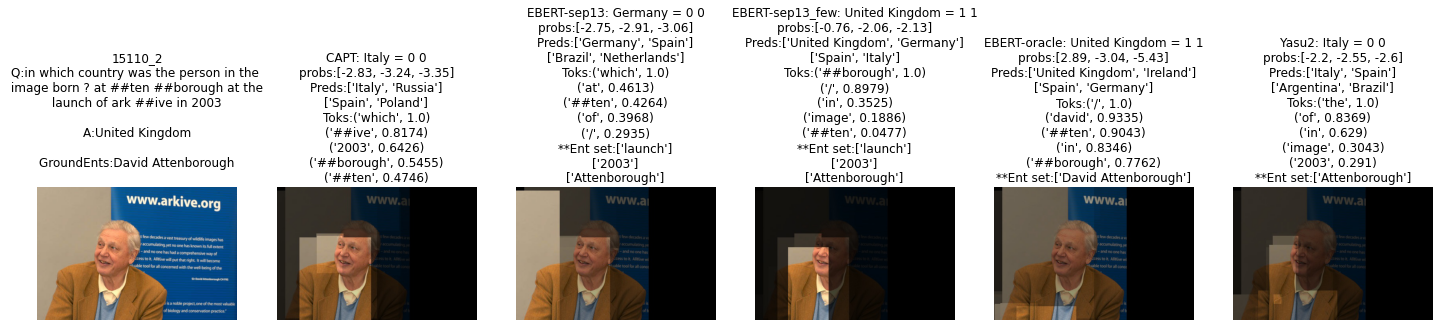

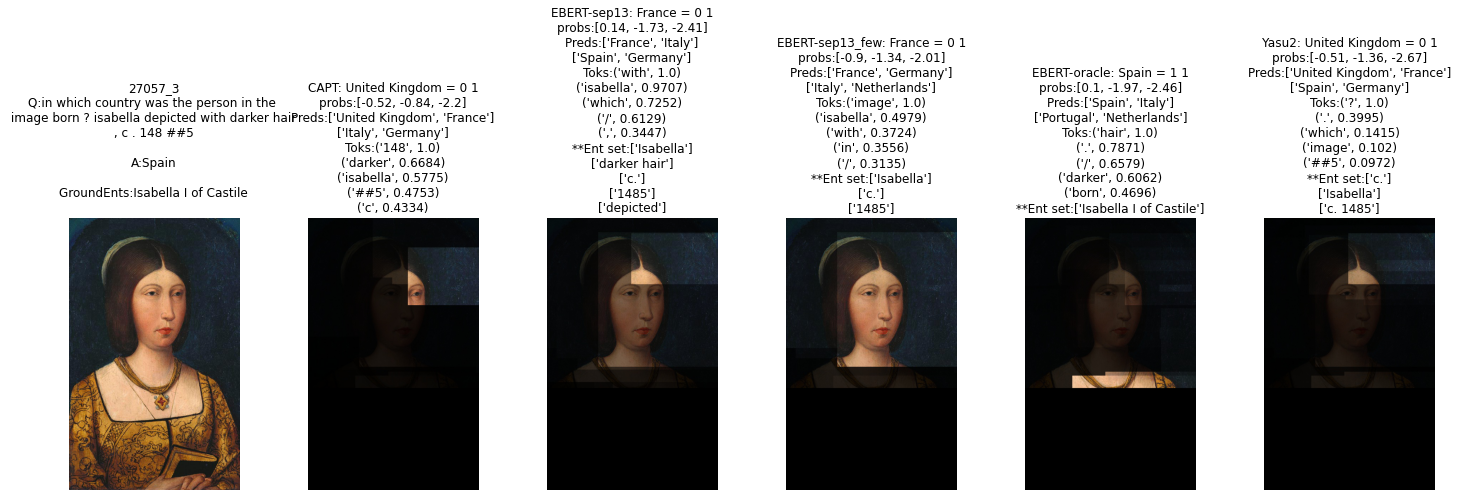

In [851]:
comps = ["EBERT-oracle vs CAPT" , "EBERT-sep13 vs CAPT", "EBERT-sep13_few vs CAPT", "Yasu2 vs CAPT"]

#qids_a = show_items_for_eval(comp_str=comps[0], with_ents=False,  cmp_type="gt", toshow = 45)  gives zero results
qids_a = show_items_for_eval(df, comp_str=comps[0], with_ents=True,  cmp_type="gt", toshow = 2)

# PRE PERTURB FIX 
"""
Looking at EBERT-oracle vs CAPT  for questions  with ent spans 18697 out of 5046 3.7053
EBERT-oracle better than  CAPT :  1550 0.3072 
EBERT-oracle worse  than  CAPT :  1151 0.2281 
EBERT-oracle and equal to CAPT : 15996 3.17
"""
# POST FIX
"""
Looking at EBERT-oracle vs CAPT  for questions  with ent spans 18697 out of 5046 3.7053
EBERT-oracle better than  CAPT :  1562 0.3096 
EBERT-oracle worse than   CAPT :  1120 0.222 
EBERT-oracle and equal to CAPT : 16015 3.1738
"""

# USING ORACLE LINKS ent set
"""
Looking at EBERT-oracle vs CAPT  for questions  with ent spans 18697 out of 5046 3.7053
EBERT-oracle better than  CAPT : 1557 0.3086 
EBERT-oracle worse than  CAPT : 998 0.1978 
EBERT-oracle and equal to   CAPT : 16142 3.199
"""
print()

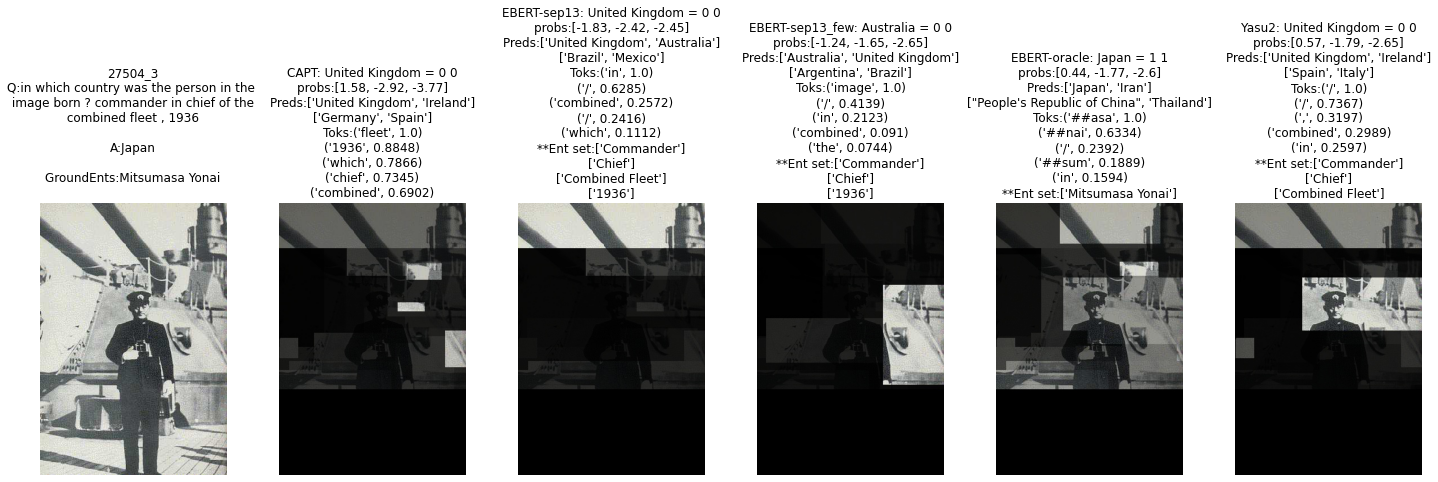

In [852]:
#good examples of oracle using ent set to get correct while no one else gets it
#'23449_3' , '27504_3'

# example of Yaus having better image explainability of face
# 20281_3, '45255_13'

qid = '27504_3'
show_kvqa_bimodal_expls_img(qid, df, okfigsize=(25,5))

In [780]:
edf[(edf.model == "EBERT-oracle") & (edf.qid == '27504_3')]

qid  val_ind         model  top1acc  top5acc  \
95372  27504_3    15895  EBERT-oracle        1        1   

                                               top5preds  \
95372  [Japan, Iran, People's Republic of China, Paki...   

                                    top5probs true_ans  num_ents  \
95372  [0.014, -2.109, -2.404, -2.98, -3.125]    Japan         1   

                             ent_set  \
95372  [[Mitsumasa Yonai, -32, -17]]   

                                               text_expl  \
95372  [0.0, 0.0573, 0.0285, 0.0128, 0.0264, 0.0675, ...   

                                                  tokens  \
95372  [[CLS], in, which, country, was, the, person, ...   

                                              image_expl  \
95372  [0.1683, 0.7988, 0.1102, 0.496, 0.1984, 0.0361...   

                                                  bboxes img_ind  \
95372  [[0.24113, 0.19582, 0.7826, 0.89754], [0.77205...   27504   

                                             ent_imps  topent_imp  \
95372  [[23, <ebert>Mitsumasa Yonai</ebert>, 0.0215]]          23   

       eberts_found  top5_uniqueness  
95372             1               -1

In [853]:
def return_importance_by_word(txt_exps, toks):
    #print("Call Return by Imp",len(txt_exps), len(toks))
    text_attrs = [ (toks[a],b) for a, b in enumerate(txt_exps) ] 
    text_attrs_sorted = sorted(text_attrs, key=lambda pair: pair[1], reverse=True)
    return text_attrs_sorted

def get_qs_for_ind(img_ind='22511',till=-1):
    eo = df[(df.model == "EBERT-oracle")&(df['img_ind'] == img_ind)]
    eks = eo.index.values[0:eo.shape[0]]
    for i, ei in enumerate(eks):
        cur = eo.loc[ei]
        q_ind = int(cur.qid.split("_")[1])
        if i == 0:
            print(img_ind, "Q:", kvqa_qs[cur.img_ind]['Questions'][q_ind] + " **Caption: " +kvqa_qs[cur.img_ind]['wikiCap'],"\n")

        imp = return_importance_by_word(cur.text_expl, cur.tokens)
        print(ei, cur.qid, len(cur.tokens) == len(cur.text_expl))
        print(cur.tokens[0:till] )
        print("\t",[(a[0],round(a[1],2)) for a in imp[0:till]])
        
def add_importance_of_eberts(df, to_show = 100):
    inds = df.index.values
    loc = []
    topent_pos = [] 
    for ii, i in enumerate(inds):
        res = []
        cur = df.loc[i]        
        cur_tokens, top_pos, imp = [], -1, []
        
        if cur.num_ents > 0:
            cur_tokens = cur.tokens
            if len(cur_tokens) == 1:
                cur_tokens = cur_tokens[0]
            imp = return_importance_by_word(cur.text_expl, cur_tokens)
            for k, im in enumerate(imp):
                #print(k, im)
                if '<ebert>' in im[0]:
                    #print("FOUND at ",ii,k,"of",len(imp),im)
                    res.append([k,im[0],im[1]])
        loc.append(res)
        if res != []:
            top_pos = res[0][0]
        topent_pos.append(top_pos)

        if ii < to_show:
            if cur.model == "Plain":
                print("")
            print("POST", i, cur.model, cur.qid, len(res), "eberts found with top at", top_pos, "of", 
                  len(imp), "****" if top_pos < 5 and top_pos > -1 else "") #, cur_tokens, "\n", imp)
            #if ii == to_show:
            #    import sys
            #    sys.exit()
            
    
    df['img_ind'] = [ v.split("_")[0] for v in df.qid.values ]    
    df["ent_imps"] = loc
    df["topent_imp"] = topent_pos
    df["eberts_found"] = [ len(l) for l in loc ]
    return df

#get_qs_for_ind(img_ind='22511',till=-1)
#df.head(2)

edf = add_importance_of_eberts(df, to_show=10)


POST 0 Plain 22511_0 0 eberts found with top at -1 of 0 
POST 1 CAPT 22511_0 0 eberts found with top at -1 of 0 
POST 2 EBERT-oracle 22511_0 1 eberts found with top at 14 of 17 
POST 3 EBERT-sep13 22511_0 1 eberts found with top at 10 of 17 
POST 4 EBERT-sep13_few 22511_0 1 eberts found with top at 3 of 17 ****
POST 5 Yasu2 22511_0 1 eberts found with top at 11 of 17 

POST 6 Plain 22511_1 0 eberts found with top at -1 of 0 
POST 7 CAPT 22511_1 0 eberts found with top at -1 of 0 
POST 8 EBERT-oracle 22511_1 1 eberts found with top at 18 of 21 
POST 9 EBERT-sep13 22511_1 1 eberts found with top at 17 of 21 


In [854]:
#mods = ['CAPT', 'EBERT-sep13', 'EBERT-sep13_few', 'EBERT-oracle', "Yasu2"]
def get_importance_stats(edf, modstr="Yasu2"):
    top1imp = edf[(edf.model == modstr)& (edf.topent_imp != -1 ) & (edf.topent_imp < 1)]
    top3imp = edf[(edf.model == modstr)& (edf.topent_imp != -1 ) & (edf.topent_imp < 3)]
    top5imp = edf[(edf.model == modstr)& (edf.topent_imp != -1 ) & (edf.topent_imp < 5)]
    top10imp = edf[(edf.model == modstr)& (edf.topent_imp != -1 ) & (edf.topent_imp < 10)]
    topmimp = edf[(edf.model == modstr)& (edf.topent_imp > -1 )]
    #topmimp2 = edf[(edf.model == modstr)& (edf.eberts_found > 0 )]  gives identical numbers to topmimp
    allmod = edf[(edf.model == modstr)] 
    str1 = "questions where ebert is in top1 importance out of "
    str3 = "questions where ebert is in top3 importance out of "
    str5 = "questions where ebert is in top5 importance out of "
    str10 = "questions where ebert is in top10 importance out of "
    print("\nModel:",modstr, " top1acc:",round(allmod.top1acc.mean(),4),", top5acc:",round(allmod.top5acc.mean(),4))
    print( "Avg Ents:",round(allmod.num_ents.mean(),2),", max:",allmod.num_ents.max(),
          ", #w num_ents >0:", allmod[allmod.num_ents >0].shape[0], round(allmod[allmod.num_ents >0].shape[0]/allmod.shape[0],4))
    print( top1imp.shape[0], str1, allmod.shape[0], "=", round( top1imp.shape[0] / allmod.shape[0], 4)) 
    print( top3imp.shape[0], str3, allmod.shape[0], "=", round( top3imp.shape[0] / allmod.shape[0], 4)) 
    print( top5imp.shape[0], str5, allmod.shape[0], "=", round( top5imp.shape[0] / allmod.shape[0], 4)) 
    print( top10imp.shape[0], str10, allmod.shape[0], "=", round( top10imp.shape[0] / allmod.shape[0], 4)) 
    print("Questions where at least one EBERT span is found", topmimp.shape[0], round( topmimp.shape[0] / allmod.shape[0], 4))

#edf = pd.read_csv("edf_kvqa0921.csv")
#get_importance_stats(edf, "EBERT-sep13")
#get_importance_stats(edf, "EBERT-sep13_few")
#get_importance_stats(edf, "Yasu2")
get_importance_stats(edf, "EBERT-oracle")

""" 
Model: EBERT-sep13      || top1acc: 0.4956 , top5acc: 0.6765
Avg Ents: 4.01 , max: 24 , #w num_ents >0: 18498 0.9894
242 questions where ebert is in top1 importance out of  18697 = 0.0129
651 questions where ebert is in top3 importance out of  18697 = 0.0348
1184 questions where ebert is in top5 importance out of  18697 = 0.0633
3458 questions where ebert is in top10 importance out of  18697 = 0.1849
Questions where at least one EBERT span is found 16980 0.9082
                     <--- using Spacy, but not force checking surface form is a WikiEmb

Model: EBERT-sep13_few  || top1acc: 0.5008 , top5acc: 0.6766
Avg Ents: 3.26 , max: 15 , #w num_ents >0: 18157 0.9711
784 questions where ebert is in top1 importance out of  18697 = 0.0419
2922 questions where ebert is in top3 importance out of  18697 = 0.1563
4524 questions where ebert is in top5 importance out of  18697 = 0.242       <-- 1st in terms of Entity Importance
8333 questions where ebert is in top10 importance out of  18697 = 0.4457
Questions where at least one EBERT span is found 18152 0.9709        
                     <--- only one where I explicitly check its in WikiEmb ( or use Wikipedia searc).. more false positives?

Model: Yasu2            || top1acc: 0.4977 , top5acc: 0.6758
Avg Ents: 2.53 , max: 13 , #w num_ents >0: 17738 0.9487
304 questions where ebert is in top1 importance out of  18697 = 0.0163
1149 questions where ebert is in top3 importance out of  18697 = 0.0615
2295 questions where ebert is in top5 importance out of  18697 = 0.1227      <---  2nd best for Entity Importance
5333 questions where ebert is in top10 importance out of  18697 = 0.2852
Questions where at least one EBERT span is found 14512 0.7762
                     <--- 2nd highest top5 with few EBERT spans found ( "person focus helps!" )

Model: EBERT-oracle     || top1acc: 0.5197 , top5acc: 0.6875
Avg Ents: 1.39 , max: 5 , #w num_ents >0: 18697 1.0
45 questions where ebert is in top1 importance out of  18697 = 0.0024
328 questions where ebert is in top3 importance out of  18697 = 0.0175
690 questions where ebert is in top5 importance out of  18697 = 0.0369         <--- worst
1647 questions where ebert is in top10 importance out of  18697 = 0.0881
Questions where at least one EBERT span is found 16252 0.8692
                     <--  String matching without forcing ent to be in WikiEmb ( which I assumed it was? )
                      <-- Highest accuracy, worst in %eberts in top important tokens , 
                      
##POST FIX FOR EBERT-oracle
Model: EBERT-oracle     || top1acc: 0.522 , top5acc: 0.6889
Avg Ents: 1.39 , max: 5 , #w num_ents >0: 18697 1.0
45 questions where ebert is in top1 importance out of  18697 = 0.0024
328 questions where ebert is in top3 importance out of  18697 = 0.0175
690 questions where ebert is in top5 importance out of  18697 = 0.0369              <--- didn't change at all?
1647 questions where ebert is in top10 importance out of  18697 = 0.0881
Questions where at least one EBERT span is found 16252 0.8692                  <--- SO REALLY THIS SHOULD BE THE COVERAGE NUMBER
       
###   1a) How would oracle do if I did force that the ent be in WikiEmb?   

Model: EBERT-oracle     || top1acc: 0.5283 , top5acc: 0.696               <-- using_oracle links
Avg Ents: 1.37 , max: 5 , #w num_ents >0: 18697 1.0
192 questions where ebert is in top1 importance out of  18697 = 0.0103
620 questions where ebert is in top3 importance out of  18697 = 0.0332
947 questions where ebert is in top5 importance out of  18697 = 0.0506
2234 questions where ebert is in top10 importance out of  18697 = 0.1195
Questions where at least one EBERT span is found 17708 0.9471


TODO: 1b) Verify all NamedEntities are in Oracle Capt and eberts are being found
"""
print()


Model: EBERT-oracle  top1acc: 0.5283 , top5acc: 0.696
Avg Ents: 1.37 , max: 5 , #w num_ents >0: 18697 1.0
192 questions where ebert is in top1 importance out of  18697 = 0.0103
620 questions where ebert is in top3 importance out of  18697 = 0.0332
947 questions where ebert is in top5 importance out of  18697 = 0.0506
2234 questions where ebert is in top10 importance out of  18697 = 0.1195
Questions where at least one EBERT span is found 17708 0.9471



In [855]:
#scratch
# edf.to_csv("edf_kvqa0921.csv",index=False)
x = edf[(edf.model == "EBERT-oracle")&(edf.qid == '24742_0')]
print([ t for t in x.tokens])
x

[['[CLS]', 'who', 'is', 'the', 'person', 'in', 'the', 'image', '?', 'hart', '##mut', 'nassau', '##er', '.', '[SEP]']]


qid  val_ind         model  top1acc  top5acc  \
140  24742_0       23  EBERT-oracle        0        0   

                                             top5preds  \
140  [Helmut Kohl, Yes, Erich Honecker, Netherlands...   

                                    top5probs          true_ans  num_ents  \
140  [-5.053, -5.167, -5.294, -5.375, -5.379]  Hartmut Nassauer         1   

            ent_set                                          text_expl  \
140  [[, -1, -1, ]]  [0.0, 0.1881, 0.0523, 0.1393, 0.1188, 0.0676, ...   

                                                tokens  \
140  [[CLS], who, is, the, person, in, the, image, ...   

                                            image_expl  \
140  [0.0824, 0.2139, 0.6968, 0.2358, 0.2244, 0.628...   

                                                bboxes img_ind ent_imps  \
140  [[0.44926, 0.46551, 0.57524, 0.57996], [0.0, 0...   24742       []   

     topent_imp  eberts_found  
140          -1             0

In [873]:
def get_topk_most_influential_examples(edf, modstr = "EBERT-oracle", k = 1, to_show=2):
    topfew = edf[(edf.model == modstr)& (edf.topent_imp != -1 ) & (edf.topent_imp < k)]
    print("Looking at",modstr," predictions where <ebert> tag is most influential token for prediction")
    inds = topfew.index.values

    for ii,i in enumerate(inds):
        cur = topfew.loc[i] 
        img_id = cur.qid.split("_")[0]
        namedentities = kvqa_qs[img_id]["NamedEntities"] 
        passed_in_ents = sep13_few_spans_dict[img_id]    #use correct ent_span
        if ii < to_show:
            print("\n",ii,cur.qid, ", top1acc:",cur.top1acc, ", pred:",cur.top5preds[0], ", top_attr:",cur.ent_imps[0],
              "\n\t" + " ".join(cur.tokens),
              "\n\t From JSON Ent Spans:",passed_in_ents["ents_found"],
             "\n\t From original NamedEntities:", namedentities)
            
    return topfew
            
r = get_topk_most_influential_examples(edf, modstr = "EBERT-oracle", k = 1)

Looking at EBERT-oracle  predictions where <ebert> tag is most influential token for prediction

 0 29832_6 , top1acc: 1 , pred: No , top_attr: [0, '<ebert>Thad Cochran</ebert>', 1.0] 
	[CLS] is the person in the image an actor ? <ebert>Thad Cochran</ebert> / tha ##d cochran during his time in the house of representatives [SEP] 
	 From JSON Ent Spans: [['Cochran', 0, 7, 'Cochran'], ['time', 19, 23, 'Time'], ['House', 31, 36, 'House'], ['Representatives', 40, 55, 'United States House of Representatives']] 
	 From original NamedEntities: ['Thad Cochran']

 1 32625_5 , top1acc: 1 , pred: No , top_attr: [0, '<ebert>Per Rune Henriksen</ebert>', 1.0] 
	[CLS] is the person in the image an actor ? <ebert>Per Rune Henriksen</ebert> / per rune henrik ##sen [SEP] 
	 From JSON Ent Spans: [['Rune Henriksen', 4, 18, 'Per Rune Henriksen'], ['Per', 0, 3, 'List of countries by GDP (PPP) per capita']] 
	 From original NamedEntities: ['Per Rune Henriksen']


In [857]:
##!pip install unidecode

# THIS BLOCK SHOWS THAT NOT ALL QUESTIONS IN THE ORACLE SET HAVE ALL ENTITIES IN THEIR CAPTIONS..
# Mostly looks like many of the cur.tokens don't include the caption ( these come from the json in the next line )
# possibly a case or unidecode thing in perturbation_kvqa.py hopefull, 

# outfile: experiments/kvqa_ebert_0_oracle_val19_f.json    made using 
"""
CUDA_VISIBLE_DEVICES=0 PYTHONPATH=`pwd` python lxmert/lxmert/perturbation_kvqa.py 
--use_lm ebert  --split_num 0 --test test_kvqa --load ../snap/kvqa/kvqa_ebert_oracle_0919_0/BEST --pred_out experiments/kvqa_ebert_0_oracle_val19_f.json
"""

def verify_oracle_examples(modstr = "EBERT-oracle", to_show = 3, error_to_show=5):
    topfew = edf[(edf.model == modstr)]      
    inds = topfew.index.values
    res = []
    err = 0
    wikicap_empty = 0
    wikicap_new_empty = 0
    for ii,i in enumerate(inds):
        cur = topfew.loc[i] 
        img_id = cur.qid.split("_")[0]
        namedentities = kvqa_qs[img_id]["NamedEntities"]
        #print(kvqa_qs[img_id].keys())
        orig_capt = kvqa_qs[img_id]["wikiCap"]
        passed_in_ents = oracle_spans_dict[img_id]
        if orig_capt == "":
            wikicap_empty +=1 
        if passed_in_ents["wikiCap_new"] == "":
            wikicap_new_empty += 1
        
        
        if ii < to_show:
            print("\n",ii,cur.qid, ", top1acc:",cur.top1acc, ", pred:",cur.top5preds[0], ", top_attr:",cur.ent_imps[0],
              "\n\t" + " ".join(cur.tokens),
              "\n\t From JSON Ent Spans:",passed_in_ents["ents_found"],
             "\n\t From original NamedEntities:", namedentities,
                 "\n\twikiCap_new:",passed_in_ents["wikiCap_new"] )
 
        curr = True
        for nent in namedentities:
            nn = "<ebert>" + unidecode(nent) + "</ebert>"            
            if nn not in cur.tokens:
                curr = False
                
        if curr == False:            
            if img_id not in res and err < error_to_show:
                err += 1
                print("\nNOT CASE for ",ii,cur.qid, "looking at ent: ", nn, 
                  "\n\t" + " ".join(cur.tokens),
                  "\n\t Importance Eberts:",cur.ent_imps,
                  "\n\t From JSON Ent Spans:",passed_in_ents["ents_found"],
                 "\n\t From original NamedEntities:", namedentities,
                     "\n\twikiCap_new:",passed_in_ents["wikiCap_new"],
                      "\n\tOrig Capt:", orig_capt)
            curr = img_id
        res.append(curr)
    print("Number of wiki capts empty", wikicap_empty, "and number of wikicap_new empty: ", wikicap_new_empty)
    return res
res = verify_oracle_examples(modstr = "EBERT-oracle",to_show=0) 

print("Number of questions where all NamedEntities are found in tokens fed to BERT:",sum([1 if r == True else 0 for r in res]))

# Number of questions where all NamedEntities are found in tokens fed to BERT: 13061 out of 18K  <--- without using unidecode
# Number of questions where all NamedEntities are found in tokens fed to BERT: 14396 out of 18 <-- using unidecode

# Number of wiki capts empty 199 and number of wikicap_new empty:  0

# Number of questions where all NamedEntities are found in tokens fed to BERT: 15281  ( using Oracle Links )

# SO ORACLE IS NOT totally right !


NOT CASE for  0 22511_0 looking at ent:  <ebert>Henry Labouchere</ebert> 
	[CLS] who is the person in the image ? <ebert>Henry Labouchère</ebert> / henry lab ##ou ##cher ##e [SEP] 
	 Importance Eberts: [[14, '<ebert>Henry Labouchère</ebert>', 0.2184]] 
	 From JSON Ent Spans: [['Henry Labouchère', 0, 16, 'Henry Labouchère']] 
	 From original NamedEntities: ['Henry Labouchère'] 
	wikiCap_new: Henry Labouchère 
	Orig Capt: Henry Labouchère

NOT CASE for  23 24742_0 looking at ent:  <ebert>Hartmut Nassauer</ebert> 
	[CLS] who is the person in the image ? hart ##mut nassau ##er . [SEP] 
	 Importance Eberts: [] 
	 From JSON Ent Spans: [['', -1, -1, '']] 
	 From original NamedEntities: ['Hartmut Nassauer'] 
	wikiCap_new: Hartmut Nassauer. 
	Orig Capt: Hartmut Nassauer.

NOT CASE for  30 15111_0 looking at ent:  <ebert>Chiezo Kataoka</ebert> 
	[CLS] who is the person in the image ? <ebert>Chiezō Kataoka</ebert> / chi ##ez ##o kata ##oka in the poster for bloody spear at mount fuji ( 1955 ) . 

In [ ]:
"""
NOW     make space
14G     snap/okvqa
63G     snap/kvqa
77G     snap/

0.1 ) make KVQA human eval stuff once Yasu2 ready  
"""

In [858]:
# this only gets split 0 info ( if edf only has split 0 results that is )
import time 
def get_ent_results(edf, modstr= "EBERT-oracle", to_show = 5):
    all_ents2 = []
    split0_img_ids = edf[edf.model == modstr].img_ind.unique()
    split0_qid0s = [ a + "_0" for a in split0_img_ids ]              #only get one question per image_id
    newdf = edf[(edf.model == modstr)&(edf.qid.isin(split0_qid0s))]

    for i in newdf.index.values:
        cur = newdf.loc[i]
        img_id = cur.img_ind
        named_ents = kvqa_qs[img_id]["NamedEntities"]
        all_ents2.append([ img_id, len(named_ents), named_ents, cur.num_ents, cur.ent_set, cur.eberts_found, cur.ent_imps, i ])
        
    for i in range(to_show):
        print(i,all_ents2[i])
    return all_ents2
    
def find_ents_missed(all_ents2): #( what are ent spans with no wiki pages )
    missed_ents = {}
    for i, r in enumerate(all_ents2):
        if r[3] > r[5]:   #if num_ent spans passed in >  ebert spans found
            nae = r[2]
            nue = set([a[0] for a in r[4]])
            ebs = set([a[1].split("<ebert>")[1].split("</ebert>")[0] for a in r[6]])
            missed = nue.difference(ebs)
            #print(r)
            #print(nae,"Passed in:",nue,"Found:", ebs,"missed:",missed)
            for m in missed:
                if m not in missed_ents:
                    missed_ents[m] = {'qids':[], 'num_ents':[]}
                missed_ents[m]['qids'].append(r[0])
                missed_ents[m]['num_ents'].append(r[3])
    return missed_ents

st = time.time()
all_ents2 = get_ent_results(edf, modstr= "EBERT-oracle", to_show = 5)
missed_ents = find_ents_missed(all_ents2)
print("Elapsed. Done: ", time.time() - st )

#print(list(missed_ents.keys())[0], missed_ents[list(missed_ents.keys())[0]])
print("\nFound",len(missed_ents),"entities whose wiki_ent_links aren't in wiki_emb")  #567 ents that are missed

""" from get_ent_results
51 ['46860', 2, ['Aleksandr Shirvindt', 'Svetlana Antonova'], 
             2, [['Aleksandr Shirvindt', 0, 19, 'Aleksandr Shirvindt'], ['Svetlana Antonova', 24, 41, 'Piranha (2006 film)']], 
             1, [[9, '<ebert>Aleksandr Shirvindt</ebert>', 0.5003]], 2222]
"""

#WAS Found 567 entities whose wiki_ent_links aren't in wiki_emb   ( then fixed <ebert> tag removal for set difference ) 
#NOW Found 484 entities whose wiki_ent_links aren't in wiki_emb

#NOW Found 20 entities whose wiki_ent_links aren't in wiki_emb ( 
print()

0 ['22511', 1, ['Henry Labouchère'], 1, [['Henry Labouchère', 0, 16, 'Henry Labouchère']], 1, [[14, '<ebert>Henry Labouchère</ebert>', 0.2184]], 2]
1 ['40917', 2, ['Dolly Parton', 'Bob Corker'], 2, [['Dolly Parton', -20, -8, 'Dolly Parton'], ['Bob Corker', 23, 33, 'Bob Corker']], 2, [[33, '<ebert>Dolly Parton</ebert>', 0.1032], [35, '<ebert>Bob Corker</ebert>', 0.0709]], 44]
2 ['24742', 1, ['Hartmut Nassauer'], 1, [['', -1, -1, '']], 0, [], 140]
3 ['15111', 1, ['Chiezō Kataoka'], 1, [['Chiezō Kataoka', 0, 14, 'Chiezō Kataoka']], 1, [[25, '<ebert>Chiezō Kataoka</ebert>', 0.1423]], 182]
4 ['34949', 1, ['Kayo Shekoni'], 1, [['Kayo Shekoni', 8, 20, 'Kayo Shekoni']], 1, [[19, '<ebert>Kayo Shekoni</ebert>', 0.0715]], 218]
Elapsed. Done:  0.49439239501953125

Found 20 entities whose wiki_ent_links aren't in wiki_emb



In [864]:
ks = list(missed_ents.keys())
for k in ks:
    print(k, len(missed_ents[k]["qids"]), np.mean(missed_ents[k]["num_ents"]))
    
del missed_ents['']

 163 1.0
Engelbrekt Engelbrektsson 1 1.0
Antonín Novotný 1 2.0
Warren E. Burger 1 3.0
H. H. Asquith 1 1.0
Nariman Narimanov 1 1.0
Joaquín Castro 1 2.0
Julian Castro 1 2.0
H. 1 3.0
Justus ǁGaroëb 1 1.0
Isabel Martínez de Perón 1 4.0
Juan Perón 1 4.0
Nicolae Ceaușescu 1 4.0
Elena 1 4.0
Ramesh Chennithala 1 5.0
Therambil Ramakrishnan 1 5.0
Oommen Chandy 1 5.0
C. N. Balakrishnan 1 5.0
Thiruvanchoor Radhakrishnan 1 5.0
López 1 2.0


In [865]:
def show_high_level_missed_ents_stats(missed_ents, to_show=5):
    ks = list(missed_ents.keys())
    for i in range(len(missed_ents)):
        if i < to_show:
            print(i, ks[i], missed_ents[ks[i]])

    namede = [v[1] for v in all_ents2]
    passedin = [v[3] for v in all_ents2]
    foundes = [v[5] for v in all_ents2]

    print("Named ents mean:",round(np.mean(namede),4), 
          "Ent set passed in mean:",round(np.mean(passedin),4), 
          "Eberts found mean: ",round(np.mean(foundes),4))  #SO ORACLE HAS ALL ENTITIES IN CAPTION.. 1.18 per q  and .99 of which are found
    # 1.186 1.186  0.9923
    
show_high_level_missed_ents_stats(missed_ents, to_show=10)

0 Engelbrekt Engelbrektsson {'qids': ['34399'], 'num_ents': [1]}
1 Antonín Novotný {'qids': ['45834'], 'num_ents': [2]}
2 Warren E. Burger {'qids': ['37420'], 'num_ents': [3]}
3 H. H. Asquith {'qids': ['19936'], 'num_ents': [1]}
4 Nariman Narimanov {'qids': ['27800'], 'num_ents': [1]}
5 Joaquín Castro {'qids': ['47153'], 'num_ents': [2]}
6 Julian Castro {'qids': ['47153'], 'num_ents': [2]}
7 H. {'qids': ['38632'], 'num_ents': [3]}
8 Justus ǁGaroëb {'qids': ['19554'], 'num_ents': [1]}
9 Isabel Martínez de Perón {'qids': ['3107'], 'num_ents': [4]}
Named ents mean: 1.1861 Ent set passed in mean: 1.1745 Eberts found mean:  1.1009


In [866]:
# add explict WikiLinks
import os
os.chdir(f'/home/diego/adv_comp_viz21/lxmert/orig_code/lxmert_gen/src/')

from lxrt.entry import load_wiki_embeddings
wiki_emb = load_wiki_embeddings()

os.chdir(f'/home/diego/adv_comp_viz21/lxmert/orig_code/lxmert/')

import wikipedia
print(wikipedia.search("battery"))

import spacy
nlp = spacy.load('en_core_web_sm') 

Loading  /data/diego/adv_comp_viz21/ebert-master/resources/wikipedia2vec/wikipedia2vec-base-cased
['Battery', 'Electric battery', 'Lithium-ion battery', 'List of battery sizes', 'Artillery battery', 'Mercury battery', 'AAAA battery', 'List of battery types', 'Alkaline battery', 'Assault and battery']


In [631]:
#get wiki title per each
import time

def find_links_for_missed_ents(missed_ents):
    # where missed_ents is a dict where keys are surface spans Hartmut Nassauer  and values are {'qids': ['24742'], 'num_ents': [1]}
    print("Attempting to find links for ", len(missed_ents))
    st = time.time()
    match_ents = []
    for i, ent_surf in enumerate(missed_ents):
        loc = []
        c = ent_surf
        doc = nlp(c.title())
        ents = [(e.text, e.label_) for e in doc.ents]
        in_wiki_emb = False

        if wiki_emb.model.dictionary.get_entity(c.title()) != None:
            keep = [c.title()]
            in_wiki_emb = True
        else:
            try:
                pos = wikipedia.search(c.title())
                if len(pos) > 0:
                    keep = []
                    for p in pos:
                        if wiki_emb.model.dictionary.get_entity(p) != None:
                            in_wiki_emb = True
                            keep.append(p)
            except Exception as e:
                print("Error on ",i,cur)
                errs.append([i,cur])

        if in_wiki_emb:            
            if len(keep) > 3:
                keep = keep[0:4]
            loc.append([ent_surf, missed_ents[ent_surf], ents, keep])  
        match_ents.append(loc)

    print("Elapsed:",time.time() - st)  
    return match_ents

match_ents = find_links_for_missed_ents(missed_ents)

Attempting to find links for  484
Elapsed: 2.700331211090088


In [867]:
#then go through them and select the match   # Showing  567  entities to link
print("Showing ",len(match_ents)," entities to link")
for i, m in enumerate(match_ents):
    if i >= 250  and i < 251:
        try:
            print("\n",i, m[0][0], m[0][1], m[0][2])    
            print("--PossibleLinks:", m[0][3])
        except Exception as e:
            print("\nERROR:",e, i, m )
    
"""
with open("kvqa_ent_spans_sep13", "w") as f:
    json.dump(ents_per_q, f)
"""

#https://en.wikipedia.org/wiki/Nathan_D._Perlman
#https://en.wikipedia.org/wiki/Ernestine_Schaffner
#https://en.wikipedia.org/wiki/Abraham_Lazarus
#https://en.wikipedia.org/wiki/Ahmed_Seada
#https://en.wikipedia.org/wiki/Andrea_Andreen
#https://en.wikipedia.org/wiki/MacDowell_(artists%27_residency_and_workshop)


#once you get these, then set match_ents and make an updated ent_spans dict and save it
"""
use_nonzero = [[10,1], [11,3], [12,2], [14,3],[27,1], [36,1],[57,1], [61,1], [62,1], [73,1],[77,1], [92,2], [101, "GroenLinks"],
              [104,3], [106, "Marie Henriette of Austria"], [110, 'Catherine Ashton'], [117,1], [120,2], [137,1], 
              [142,1], [145,"National Unemployed Workers' Movement"], [167,1], 
              [176, "Dakota War of 1862"],[181,3], [184,1],[187,2], [188, "Norwegian Confederation of Trade Unions"], [196,"Conducting"],  
              [202,1],[204,1],[207,"Liberalism in Austria"],[212, "Kingdom of Prussia"], [219,1],[220,1],[223,3],[224,1],
              [226,"Anzia Yezierska"],[237,1]]

# some of these are empty, some are wong, some are first names that go to a fullname ( check these examples by looking at question/ent set )
skip = [21, 23, 33, 34, 66, 75,79,96, 124, 126, 213, ] 
"""


# DIDN'T DO ANY MANUAL STUFF AS IT WAS TOO TIME CONSUMING ( INSTEAD DON'T USE wikipedia API at all if not direct hit )

# A) For rest just use 0 .. make code
""""
print("\n")
def update_ent_spans( oracle_spans_dict, match_ents, missed_keys, use_nonzero=[], skip=[] ):
    use_nonzero_inds = {k[0]:k[1] for k in use_nonzero}
    ent_surf_same_as_wiki_link, updated = 0, 0
    missed_keys = list(missed_ents.keys())
    for i, m in enumerate(match_ents):
        wiki_ent = -1
        if i not in skip:
            if i in use_nonzero_inds:
                wiki_ent = use_nonzero_inds[i]
                if type(wiki_ent) != str:
                    wiki_ent = m[0][3][wiki_ent]
            else:
                if len(m) > 0:
                    # default to first result
                    wiki_ent = m[0][3][0]

        if len(m) > 0:
            ent_surf = m[0][0]
            ids = m[0][1]['qids']
        else:
            ent_surf = missed_keys[i]
            ids = missed_ents[missed_keys[i]]['qids']

        if wiki_ent == -1 and i not in skip:
            wiki_ent = ent_surf


        for img_id in ids:
            
            named_ents = kvqa_qs[img_id]["NamedEntities"]
            capts = kvqa_qs[img_id]["wikiCap"]
            passed_in_ents = oracle_spans_dict[img_id]
                
            cur_ents = passed_in_ents["ents_found"]
            for ii, e in enumerate(cur_ents):
                if e[0] == ent_surf:
                    new_e = [ent_surf,e[1],e[2],wiki_ent]
                    x = edf[(edf.qid == img_id + '_0')&(edf.model == "EBERT-oracle")]
                    oracle_spans_dict[img_id]["ents_found"][ii] = new_e
                    updated += 1
                    comm = ""
                    if ent_surf == wiki_ent:
                        comm = "***"
                        ent_surf_same_as_wiki_link +=1 
                    print("\n",i, comm, "For ",img_id," Change ",e," to ",new_e)
                    print("\t", " ".join([t for t in x.tokens][0]))
                    
                    if i in skip:# or ent_surf == wiki_ent:
                        print("\n",i, passed_in_ents, img_id,
                              "\n\tpossible links:", m[0][3] if len(m) > 0 else [],
                              "\n\tgive surface:", ent_surf," link of:", wiki_ent,
                              "\n\t",named_ents,capts)
     
    print("\nDONE")
    print("updated: ", updated)
    print("# where ent_surf_same_as_wiki_link: ", ent_surf_same_as_wiki_link)
    print("Out of ", len(match_ents))
    return oracle_spans_dict
    
new_oracle_spans2 = update_ent_spans( oracle_spans_dict, match_ents, missed_keys, use_nonzero=[], skip=[])                    

#new_oracle_spans

# to update

to_up = {
        45097: ['Grand Duke Sergei Alexandrovich of Russia with his younger brother Grand Duke Paul Alexandrovich of Russia',
                 [['Grand Duke Sergei Alexandrovich of Russia', 0, 41], ['Grand Duke Paul Alexandrovich of Russia', 67, 106]]],
        46099 : ['Thomas Broich, with Thomas Kessler in 2009',
                 [['Thomas Broich', 0, 13, 'Thomas Broich'], ['Thomas Kessler', 20, 34, 'Thomas Kessler']]],
        38632 : [ 'George H. Bush speaks on the telephone regarding Operation Just Cause with General Brent Scowcroft and Chief of Staff John H. Sununu, 1989',
               [['George H. Bush', 0, 14], ['Brent Scowcroft', 83, 98], ['John H. Sununu', 118, 132]]]
        }
for img_id in to_up:
    new_oracle_spans2[img_id]["wikiCap_new"] = to_up[img_id][0]
    new_oracle_spans2[img_id]["ents_found"] = to_up[img_id][1]
"""
    
    
"""
#34399  <-- WATCH OUT as this is not due to WikiLinks or start/end positions at all !!!!   is it due to wordpieces!  <-- IMPORTANT TO FIX THIS!!


new_wikiCap = 'Late 19th century model for a statue of Engelbrekt Engelbrektsson to be placed in Örebro'
new_entsfound  = [['Engelbrekt Engelbrektsson', 0, 0, 'Engelbrekt Engelbrektsson']]

#[['Engelbrekt Engelbrektsson', 40, 65, 'Engelbrekt Engelbrektsson']]} 

for i, n in enumerate(new_entsfound):
    new_entsfound[i][1] = new_wikiCap.index(n[0])
    new_entsfound[i][2] = new_entsfound[i][1] + len(n[0])
print(new_entsfound)
"""

#     updated:  498
#     where ent_surf_same_as_wiki_link:  280
#     Out of  484

# NEXT LOOK THROUGH kvqa_test code on split 0 and find why some of the below aren't found exactly ( make space afterwards )
# so really its just a question of title case not matching well for many ...

# SO NOW go through entire oracle_ent_spans dict and do the check in wiki_emb and if not add first from wikipedia .  
# 
print()

Showing  484  entities to link

 250 Victor de Stuers {'qids': ['23927'], 'num_ents': [1]} [('Victor De Stuers', 'PERSON')]
--PossibleLinks: ['Victor de Stuers', 'Girl with a Pearl Earring', 'Historic preservation', 'Maastricht']



In [619]:
x = edf[(edf.qid == '45658_0')&(edf.model == "EBERT-oracle")]
print([t for t in x.tokens])
x

[['[CLS]', 'who', 'is', 'in', 'the', 'left', '?', '<ebert>Stephanie Mcmahon</ebert>', '/', 'stephanie', 'mcmahon', 'hunt', '(', 'left', ')', 'with', 'future', 'chief', 'justice', 'of', 'the', 'arizona', 'supreme', 'court', ',', 'jesse', 'addison', 'ud', '##all', '.', '[SEP]']]


qid  val_ind         model  top1acc  top5acc  \
102770  45658_0    17128  EBERT-oracle        0        0   

                                                top5preds  \
102770  [Gerald Ford, Wyatt Earp, John F. Kennedy, Abr...   

                                       top5probs           true_ans  num_ents  \
102770  [-3.373, -4.097, -4.252, -4.464, -4.581]  George W. P. Hunt         2   

                                                  ent_set  \
102770  [[Hunt, 0, 4, Hunting], [Stephanie McMahon, -2...   

                                                text_expl  \
102770  [0.0, 0.1639, 0.3754, 0.5891, 0.4303, 0.3595, ...   

                                                   tokens  \
102770  [[CLS], who, is, in, the, left, ?, <ebert>Step...   

                                               image_expl  \
102770  [0.1585, 0.1092, 0.03, 0.2903, 0.1058, 0.03, 0...   

                                                   bboxes img_ind  \
102770  [[0.0, 0.32517, 0.4235, 0.93292], [0.04406, 0....   45658   

                                                ent_imps  topent_imp  \
102770  [[27, <ebert>Stephanie Mcmahon</ebert>, 0.1353]]          27   

        eberts_found  
102770             1

In [ ]:
# FOR WHEN YOU HAVE ALL SPLITS

# B) This is only affecting test cases for split 0  so I should do it over all test splits ( since that covers all the data ) <-- so that 
# the training goes better to ( just use 0 for all )

import time
def get_oracle_records():
    ebert_records_sp1 =  json.load(open("experiments/kvqa_ebert_1_newlxmo_0905.json")) # [52.20, 69.20, 9660, 12805, 18505]
    ebert_records_sp2 =  json.load(open("experiments/kvqa_ebert_2_newlxmo_0905.json")) # [52.12, 69.20, 9745, 12937, 18696]
    ebert_records_sp3 =  json.load(open("experiments/kvqa_ebert_3_newlxmo_0901.json")) # [53.18, 69.42, 10236, 13361, 19248]
    ebert_records_sp4 =  json.load(open("experiments/kvqa_ebert_4_newlxmo_0905.json")) # [52.15, 68.82, 9449, 12471, 18120]

    return [ebert_records_sp1, ebert_records_sp2, ebert_records_sp3, ebert_records_sp4]

def make_edf_for_split(ebert_records):
    tokenize = False 
    toshow = 2
    pd_rows = []
    for ind, k in enumerate(plain_records):
        imgid = k.split("_")[0]
        q = int(k.split("_")[1])
        cur_dict = {'EBERT-oracle':ebert_records[k]}
        cur_ents = {'EBERT-oracle':oracle_spans_dict[imgid]["ents_found"]}

        true_ans = ebert_records[k]['true_ans']
        capt = kvqa_qs[imgid]['wikiCap']
        oracle_capt = oracle_spans_dict[imgid]['wikiCap_new']
        sent = kvqa_qs[imgid]['Questions'][q]
        if ind < toshow:
            print("\n"+k, sent,'\ntrue_ans', true_ans )    #true ans is incorrectly saved so use from questions directly    

        # perturbation_okvqa.py now passes in "tokens" in records 
        # whereas here we don't have it have it for Plain, CAPT or EBERT-oracle
        # so we need to either re-run those threes perturb_kvqa or load tokenizer to do it

        for i in cur_dict:
            v = cur_dict[i]
            tokens = v["tokens"]            
            try:
                if ind < toshow:
                    print(i, "\t", round(v['top1acc'],3), "\t", v['top5'], [round(b,3) for b in v['top5probs']], "\t", v['top5acc'] )

                pd_rows.append([k,ind, i, round(v['top1acc'],3), v['top5acc'], v['top5'],[round(b,3) for b in v['top5probs']],
                                true_ans, len(cur_ents[i]), cur_ents[i], v['text_expl'], tokens, v['image_expl'], v['bboxes']])
            except Exception as e:
                print(k,ind,i,v,e)
                import sys
                sys.exit()

    df = pd.DataFrame(pd_rows, columns=["qid","val_ind","model","top1acc","top5acc","top5preds","top5probs","true_ans",
                                        "num_ents","ent_set","text_expl","tokens","image_expl","bboxes"]) 
    edf = add_importance_of_eberts(df, to_show=10)
    return edf


#TODO GET RESULTS FOR OTHER SPLITS THIS WAY
#all_ents2 = get_ent_results(modstr= "EBERT-oracle", edf, to_show = 5)
#missed_ents = find_ents_missed(all_ents2)

In [ ]:
# TODOs
# XXX1. SHOW ENTITIES beneath Left Answer provided with question ( is oracle using them )
# xxx 2. DO work from server now that things are done to get yasu work

# XXXCAN WE USE ROI labels to inject knowledge?  ( is this stored in frcnn features please please please )
#   https://colab.research.google.com/drive/1klgx95SJY_W5feII6rCdCkaHBizShtAD#scrollTo=sun0d4RHbGhZ
#   it could get us man or woman, maybe colors, but it'd be hard to discern how many of each so its probably useless   <--- SO DON'T GO DOWN THIS HOLLE



# NOW: Look into the few things you mentioned in Yasu's email ( is Oracle correct, could it be made better, etc)
# 1.. am I not actually including all ents in the caption for Oracle case?
#     if not, make an ent set/ model that actually does that ( which i think will maybe lead to even more acc )
#   ... ISSUE WAS THERE WAS A BUG ON THE CASE when an ent span was given and it was the last in the list
#    --> pretty sure there are other issues, but for now retrain kvqa for oracle ( this affected everything )

# FIXED CODE ON src/lxrt/entry and modelling ( as per lxmert/lxmert/src/lxmert_lrp_ebert )
# This doesn't help identify more ebert spans, it just adds back entity as plain text in cases where that wasn't happening


# So for 1.. check what avg ents is per img_id for KVQA and what the ent_sets look for ORACLE  ( which is what we try to pass in )
#            and compare against the eberts_found ... if we are passing in all possible ents, then the only thing to do is try and "enhance"  <-- so do this!


# 2..I could possibly take your model ent spans json ( and oracles ) 
#      and make a v3 that went through the ent spans and checked if they exist in WikiEmb and 
#      if not look up nearest result using the Wikipedia search via that python library and change the ent spans as such, 
#      then run a new model to see how it does ( FOR ORACLE, this would have lead to about 2400 cases that are likely to be noisy ( less than 50% accurate )

# XXX 4. Check if we need to redo ORACLE ENTITIES ( I think that angle is important.. how good could you do )
# see how new training of Oracle is coming along
# Instead of doing Enhance, I just created 4 span version and reran (without wikienhance) and removed spans which didn't occur in wikiemb
# NOW run this new oracle_links   <--- THIS IS HAPPENING NOW  ..  this could be helpful for Yasu work



## vv Do below on existing ORACLE results even if we'll need to change them

#* Instead of just presenting random 50 per 4 use cases ( ebert better without / with ents  and plain better without / with ents 
,
## XXX
# 2. A find examples with biggest difference in top5 regardles
#       use   1 - (Jaccard Similarity) where :  J(A, B) := |A ∩ B| / |A ∪ B|   ( ie the models top 5 sets intersection means less interesting.. ) 
#      OR also where one set ( say oracle ) is very different from rest! 

## XXX
# 2. B find examples where EBERT is actually influential!    
#      what if i only trained on cases with EBERT and then used another model for non EBERT?
#       -- is it possible the model is learning to discard the ebert reps in most cases since its not prevelant quite a bit?
#            --> if possible, moreso likely with OKVQA since with KVQA we always have at least 90% of questions with ent sets

# SO NOW do 3, then revisit / recalculate 2B   <---

# 3. Check attribution is correct.  
#   Make sure my assumption about starting / ending with [CLS] + [SEP]  is correct ( basically assert len(toks) == len(txt_exps ))
#   and make sure you join wordpieces before showing end results


# 5. Should I be training with a [SEP] between question and caption?  Right now it looks like most of attention is on non-ebert tokens
#     Calculationg what attribution is getting put on the EBERT tokens in general

# 6  If its low is it the linear mapper from WikipediaVec to BERT space the issue?  
#     What if instead of linear we use an mlp?   is there a VQA dataset with entity spans?   
#     Can we reformulate the questions as statements for retrieval like Jialin did?

# 7.  Is this the first paper to look at feature attribution of entity injection on both text and image side?

# xxx 8.  FUTURE: Ways to compare specific vs broad ent spans

# 9.  Better Metric for eval since both sets are sooooo noisy
# 10) Is there value in an automated Mutual info, simulatability or perturbation based analysis as opposed to just Human eval? 

# 
# 11a) Can we use TOP 5 answer sets "sameness" between models and then accuracy as a notion of question difficulty?  
    # For a given questions if all the models agree in their top 5 predicted answers ( just different orders ) regardless of correctness on answerset
    #  that is probably easier than a question
    #  where the models give more varied and disjoint answers?  

# 11b) Related.. In some of these questions the actual top preds from the model are much better than the answers given by the humans and 
#     if they have high alignment and mismatch in some way with the answer set provided 
#      that could be a way to assess and improve answer set quality in some way potentially?


In [715]:
#1. REDOING ORACLE ENT SPANS DICT TO CREATE ORACLE_LINKS SET 

import time
import copy

def find_links_for_oracle_set(oracle_spans_dict):
    # where missed_ents is a dict where keys are surface spans Hartmut Nassauer  and values are {'qids': ['24742'], 'num_ents': [1]}
    noracle_spans_dict = copy.deepcopy(oracle_spans_dict)
    print("Attempting to find links for ", len(noracle_spans_dict))    
    st = time.time()    
    for i, img_id in enumerate(noracle_spans_dict):
        loc = []
        cur = noracle_spans_dict[img_id]["ents_found"]
        #print(cur)
        cur_entsfound = []
        for ii, ent_surf in enumerate(cur): 
            c = ent_surf[0]
            
            doc = nlp(c) #.title())
            ents = [(e.text, e.label_) for e in doc.ents]

            #print("\n",i,c, ents, len(cur))
            in_wiki_emb = False
            use_wiki_api = False
            if wiki_emb.model.dictionary.get_entity(c) != None:   #got rid of c.title()
                #print("--A")
                keep = [c] #.title()]
                in_wiki_emb = True
            """  this is too noisy ( its maybe 50/50 at best )
            else:
                #print("--B")
                use_wiki_api = True
                try:
                    pos = wikipedia.search(c.title())
                    if len(pos) > 0:
                        keep = []
                        for p in pos:
                            if wiki_emb.model.dictionary.get_entity(p) != None:
                                in_wiki_emb = True
                                keep.append(p)
                except Exception as e:
                    print("Error on ",i,cur)
                    errs.append([i,cur])
            """
            if in_wiki_emb:            
                if len(keep) > 0:
                    if not use_wiki_api:
                        keep = keep[0]
                        cur_entsfound.append([ c, ent_surf[1], ent_surf[2], keep])
                    if use_wiki_api:
                        print("\n",i,c, ents, ii, len(cur))
                        print("add wiki api", [ c, ent_surf[1], ent_surf[2], keep])
                        cur_entsfound.append([ c, ent_surf[1], ent_surf[2], keep[0]])
                else:
                    # this ent_surf was not directly in wiki_emb and its wikipedia api call returned nothing
                    print("REMOVE", [ c, ent_surf[1], ent_surf[2], keep])
                    keep = -1
                    
        if cur_entsfound != []:
            noracle_spans_dict[img_id]["ents_found"] = cur_entsfound  
        else:
            noracle_spans_dict[img_id]["ents_found"] = [['',-1,-1,'']]
            
        #if i > 3000:
        #    import sys
        #    sys.exit()

    print("Elapsed:",time.time() - st)  
    return noracle_spans_dict

boracle_spans_dict_with_wikis = find_links_for_oracle_set(oracle_spans_dict)   #this will now be 4 length 


#Elapsed: 1231.75  = 21 minutes
#Elapsed: 152.82 without wikipedia

#fix = { 42:[0,4], 192:[0,3], 216:[0,2], }    #SO TRY WITHOUT USING

Attempting to find links for  24602
Elapsed: 151.69318985939026


In [657]:
#oracle_spans_dict_with_wikis['45472']['ents_found']

[['Najib Razak', 0, 11],
 [['Najib Razak', 0, 11, 'Najib Razak'],
  ['Susilo Bambang Yudhoyono', 27, 51, 'Susilo Bambang Yudhoyono']]]

In [868]:
#back_oracle_with = oracle_spans_dict_with_wikis
"""
oracle_spans_dict = json.load(open(abs_path + "data/kvqa/new_kvqa_q_caps_ents0502.json"))
or_lens = [ len([ 1 for e in oracle_spans_dict[o]["ents_found"] if e != []]) for o in oracle_spans_dict]
#nor_lens = [ len([ 1 for e in boracle_spans_dict_with_wikis[o]["ents_found"] if e != []]) for o in boracle_spans_dict_with_wikis]
nor_lens = [ len([ 1 for e in boracle_spans_dict_with_wikis[o]["ents_found"] if e[0] != '']) for o in boracle_spans_dict_with_wikis]

#os = sum([ 1 for o in or_lens if o == 0 ])   #0
#nos = sum([ 1 for o in nor_lens if o == 0 ]) #0

print(sum(or_lens), os, "\n",sum(nor_lens), nos)  

"""
#for 24K questions
#28930 0   there are 28930 ents
#27443 0   <--and forcing them to be explicitly link gets rid of 1487 ents   or 27210 0

#for o in oracle_spans_dict:
#    if len(oracle_spans_dict[o]["ents_found"]) == 0
    


"""
unq_ents = []
for o in oracle_spans_dict:
    for e in oracle_spans_dict[o]["ents_found"][0]:
        print(oracle_spans_dict[o])
        print(e)
        import sys
        sys.exit()


unq_ents_or = set([ e[0] for o in oracle_spans_dict for e in oracle_spans_dict[o]["ents_found"]])
unq_ents_nor = set([ e[0] for o in oracle_spans_dict for e in boracle_spans_dict_with_wikis[o]["ents_found"]])

print("Original:", sum(or_lens), len(unq_ents_or))
print("vs WikiEmb Checked:", sum(nor_lens), len(unq_ents_nor))
"""

# hmmm.. 28930 28930 without the [0]   
#... with the correct [0] in place.. 73806 31519   ( using wikiapi )
#    wihtout using wiki  73806 29999

"""
ks = list(boracle_spans_dict_with_wikis.keys())
for i in range(len(ks)):
    if i < 2:
        print(i,ks[i],
              "\n", oracle_spans_dict[ks[i]]["ents_found"],
              "\n", boracle_spans_dict_with_wikis[ks[i]]["ents_found"])
        
    if i < 10:            
        for e in boracle_spans_dict_with_wikis[ks[i]]["ents_found"]:
            if len(e) != 1:
                print("SUPERWEIRD", i,ks[i], e)
            elif len(e[0]) < 4:
                print("WEIRD", i,ks[i], e)
            elif e[0][0] != e[0][3]:
                print("NOTEQUAL", i,ks[i], e)
"""

"""
with open("kvqa_oracle_ent_spans_with_wikis0923.json", "w") as f:
    json.dump(boracle_spans_dict_with_wikis, f)
"""

print()

In [869]:
edf.head(2)

qid  val_ind  model  top1acc  top5acc  \
0  22511_0        0  Plain        0        0   
1  22511_0        0   CAPT        0        0   

                                           top5preds  \
0  [Paul Kruger, Yes, Abraham Lincoln, No, John C...   
1                  [Yes, No, Paul Kruger, Europe, 2]   

                                  top5probs          true_ans  num_ents  \
0  [-5.373, -5.563, -5.804, -5.951, -5.995]  Henry Labouchère         0   
1    [-5.382, -5.44, -5.573, -6.022, -6.17]  Henry Labouchère         0   

  ent_set                                          text_expl  \
0      []  [0.0, 0.9214, 0.5653, 0.9158, 0.9288, 0.8837, ...   
1      []  [0.0, 1.0, 0.0886, 0.0977, 0.1531, 0.0878, 0.0...   

                                              tokens  \
0          [who, is, the, person, in, the, image, ?]   
1  [who, is, the, person, in, the, image, ?, henr...   

                                          image_expl  \
0  [0.0296, 0.2335, 0.4365, 0.123, 0.0763, 0.1164...   
1  [0.1201, 0.2492, 0.524, 0.4115, 0.196, 0.2486,...   

                                              bboxes img_ind ent_imps  \
0  [[0.36644, 0.32435, 0.51792, 0.55949], [0.1491...   22511       []   
1  [[0.36644, 0.32435, 0.51792, 0.55949], [0.1491...   22511       []   

   topent_imp  eberts_found  
0          -1             0  
1          -1             0

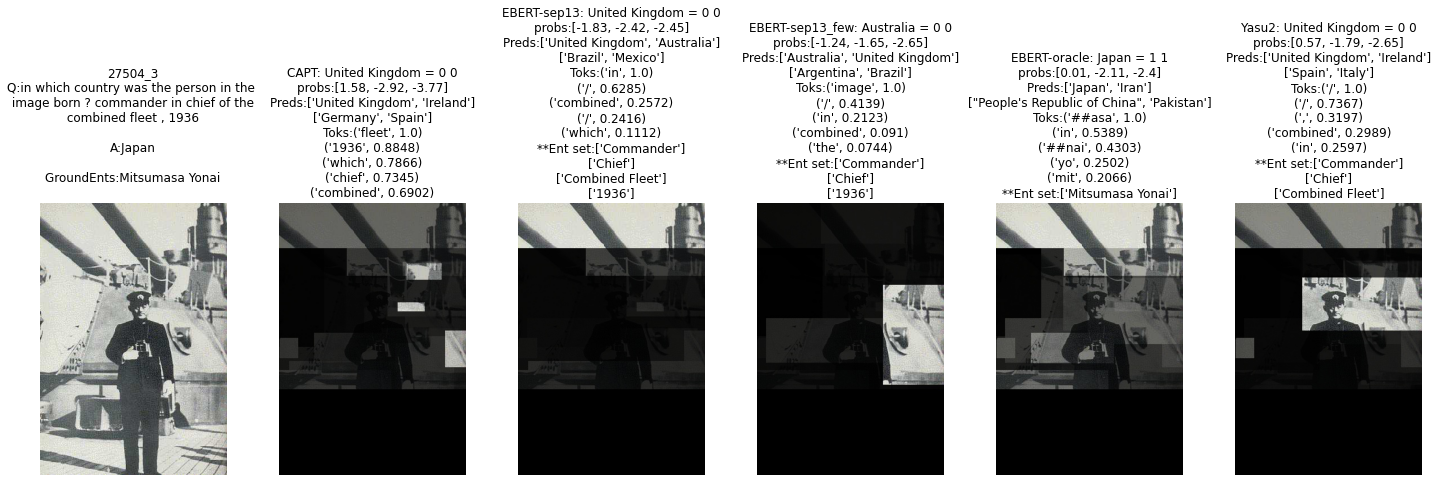

In [753]:
qid = '27504_3'  #'27504_3'  # 
show_kvqa_bimodal_expls_img(qid, df, okfigsize=(25,5))

In [927]:
# 9/24 add qtype to edf and then do nedf step in next and save
import copy
import time 

def construct_qid2qtypes(kvqa_qs):
    unq_types = {}
    qid2qtype = {}
    qs, qerrs = 0, []
    for imgid in list(kvqa_qs.keys()):
        imgdata = kvqa_qs[imgid]
        for i,q in enumerate(imgdata['Questions']):
            qs += 1
            qid = imgid + "_" +str(i)
            try:
                qtype = imgdata['Type of Question'][i]
                found_cmb = False
                for ii, qt in enumerate(qtype):
                    if '1-hop ' in qt:
                        found_cmb = True
                        qtype[ii] = qt.split("1-hop ")[1]
                if found_cmb:
                    qtype.append('1-hop')
                
                for t in qtype:
                    if t not in unq_types:
                        unq_types[t] = 0
                    unq_types[t] +=1 
                    
                qid2qtype[qid] = qtype
            except Exception as e:     
                #print("Error on ",i,len(imgdata['Type of Question']))  #issue of type of questions being one less than num questions
                qid2qtype[qid] = []
                qerrs.append(qid)
                
    print("no question type for ", len(qerrs), "out of ", qs)          #68 out of  183007
    return qid2qtype, qerrs, unq_types

def add_question_types_to_df(edf, qid2qtype, debug=False):
    fedf = copy.deepcopy(edf)
    fedf["q_hops"] = ""
    #fedf["q_type"] = ""
    qtype_cols = ["Multi-Relation", "boolean", "Multi-Entity", "comparison", "spatial", "subtraction", "counting", "intersection"]
    for qt in qtype_cols:
        fedf[qt] = 0

    qids = list(fedf.qid.unique())
    print(len(qids))
    for i, q in enumerate(qids):
        if debug:
            print("looking at i,q",i,q)
        
        qtypes = qid2qtype[q]
        level = '1-hop'
        if '1-hop' not in qtypes:
            level = 'multi-hop'
        
        if debug:
            print("found qtypes:", qtypes, "and LEVEL:", level)
        fedf.loc[(fedf.qid == q),"q_hops"] = level
        
        try:
            ind = qtypes.index(level)            
            qtypes = [ v for ii,v in enumerate(qtypes) if ii != ind ]
            if debug:
                print("adding qtypes:", qtypes )
                
            for qtv in qtypes:
                if qtv not in qtype_cols:
                    print("DIDN'T FIND", qtv, level, q)
                    if qtv != "Italy":
                        import sys
                        sys.exit()
                else:  
                    fedf.loc[(fedf.qid == q),qtv] = 1
                
        except Exception as e:
            print("Error on ",i,q,e,qtypes) 
        
        if i < 10:
            print(i, q, level, qtypes)
        
    return fedf

st = time.time()
qid2qtype, qerrs, unq_types = construct_qid2qtypes(kvqa_qs)
#fedff = add_question_types_to_df(edf, qid2qtype)        
#print("Done. Elapsed:", time.time() - st) #Done. Elapsed: 325.34  = 5.5 minutes

#print(unq_types)
"""
{'1-hop': 144230, 
 'Multi-Relation': 102634, 
 'subtraction': 18843, 
 'boolean': 52539, 
 'comparison': 28966, 
 'Multi-Entity': 55414, 
 'multi-hop': 38709, 
 'counting': 19000, 
 'spatial': 14632, 
 'intersection': 7466,  
"""
print()

no question type for  68 out of  183007
{'1-hop': 144230, 'Multi-Relation': 102634, 'subtraction': 18843, 'boolean': 52539, 'comparison': 28966, 'Multi-Entity': 55414, 'multi-hop': 38709, 'counting': 19000, 'spatial': 14632, 'intersection': 7466, 'France': 4, 'Italy': 23, 'Israel': 3, 'Who among the people in the image ever married to Bernadette Chirac?': 1, 'Person in the left': 1, "People's Republic of China": 1, 'How many is/are basketball coach among the people in the image?': 1, '1': 1, 'How many people in the image belong to Democratic Party?': 1, '2': 1, 'Who among the people in the image ever married to Barack Obama?': 1, 'Person second from left': 1, 'No': 1, 'Yes': 1}



In [935]:
def show_type_break_down(fedff, mod_str="EBERT-oracle"):
    qtype_cols = ["Multi-Relation", "boolean", "Multi-Entity", "comparison", "spatial", "subtraction", "counting", "intersection"]
    #del fedf["Italy"]
    print(mod_str, "results by type")
    levels = ["1-hop","multi-hop"]
    for l in levels:
        c = fedff[(fedff.model == mod_str)&(fedff.q_hops == l)]
        print("\nFOR LEVEL ", l, ". examples:",c.shape[0])
        print("\t type |  top1 acc | num examples")
        for qc in qtype_cols:
            if l=="1-hop" or (l == "multi-hop" and qc not in ["comparison","spatial","subtraction"]):
                cur = fedff[(fedff.model == mod_str)&(fedff.q_hops == l)&(fedff[qc] == 1)]
                print("\t"+qc, round(cur.top1acc.mean(),4), cur.shape[0])

    print("Total qids:", len(list(fedff.qid.unique())))
    
#make function to show comparison by type between models (ie, )
    
show_type_break_down(fedff, mod_str="Yasu2")
"""
EBERT-oracle results by type ****************************
FOR LEVEL  1-hop . examples: 14682
	 type |  top1 acc | num examples
	Multi-Relation 0.473 6482
	boolean 0.874 4681
	Multi-Entity 0.7207 4289
	comparison 0.8278 2921
	spatial 0.0497 1530
	subtraction 0.1286 1866
	counting 0.8385 1257
	intersection 0.791 445

FOR LEVEL  multi-hop . examples: 4015
	 type |  top1 acc | num examples
	Multi-Relation 0.6993 4007
	boolean 0.7213 653
	Multi-Entity 0.6981 1378
	counting 0.6772 725
	intersection 0.7156 327
Total qids: 18697

Yasu2 results by type ****************************
FOR LEVEL  1-hop . examples: 14682
	 type |  top1 acc | num examples
	Multi-Relation 0.4372 6482
	boolean 0.8669 4681
	Multi-Entity 0.7204 4289
	comparison 0.8264 2921
	spatial 0.0516 1530
	subtraction 0.1158 1866
	counting 0.8377 1257
	intersection 0.7798 445

FOR LEVEL  multi-hop . examples: 4015
	 type |  top1 acc | num examples
	Multi-Relation 0.6374 4007
	boolean 0.6937 653
	Multi-Entity 0.6785 1378
	counting 0.6648 725
	intersection 0.6758 327
"""
fedff.head(1)

Yasu2 results by type

FOR LEVEL  1-hop . examples: 14682
	 type |  top1 acc | num examples
	Multi-Relation 0.4372 6482
	boolean 0.8669 4681
	Multi-Entity 0.7204 4289
	comparison 0.8264 2921
	spatial 0.0516 1530
	subtraction 0.1158 1866
	counting 0.8377 1257
	intersection 0.7798 445

FOR LEVEL  multi-hop . examples: 4015
	 type |  top1 acc | num examples
	Multi-Relation 0.6374 4007
	boolean 0.6937 653
	Multi-Entity 0.6785 1378
	counting 0.6648 725
	intersection 0.6758 327
Total qids: 18697


qid  val_ind  model  top1acc  top5acc  \
0  22511_0        0  Plain        0        0   

                                           top5preds  \
0  [Paul Kruger, Yes, Abraham Lincoln, No, John C...   

                                  top5probs          true_ans  num_ents  \
0  [-5.373, -5.563, -5.804, -5.951, -5.995]  Henry Labouchère         0   

  ent_set  ... eberts_found q_hops Multi-Relation boolean Multi-Entity  \
0      []  ...            0  1-hop              1       0            0   

  comparison  spatial  subtraction counting  intersection  
0          0        0            0        0             0  

[1 rows x 27 columns]

In [936]:
fedff.to_csv("fedff0924.csv", index=False)

In [937]:
 ### 9/23 
    
# 2. A find examples with biggest difference in top5 regardles
#       use   1 - (Jaccard Similarity) where :  J(A, B) := |A ∩ B| / |A ∪ B|   ( ie the models top 5 sets intersection means less interesting.. ) 
#      OR also where one set ( say oracle ) is very different from rest! 

# basically where does "modstr" top5 have least overlap with union of other models
def get_ansset_similairty(edf, qid='27504_3', modstr="EBERT-oracle", debug=False):
    cur = edf[(edf.model == modstr)&(edf.qid == qid)]
    curset = set(list(cur.top5preds.values[0]))
    others = edf[(edf.model != modstr)&(edf.qid == qid)]
    otherset = []
    for ind in others.index.values:
        oc = others.loc[ind]        
        oct5 = oc.top5preds
        otherset.extend(oct5)
    otherset = set(otherset) 

    found = 0    
    for f in curset:
        if f in otherset:
            found +=1 
        
    score = found / len(curset)
    if debug:
        print("\nComparing ",modstr, cur.shape, cur.model.values, curset)
        print("TO REST", others.shape, others.model.values, otherset, len(otherset))
        print(found," found over collective set of ",len(otherset), ".  Score=", score)
        
    return score

def get_all_scores_for_qid(edf, qid="27504_3", debug=False):
    mods = {'Plain':-1,'CAPT':-1,'EBERT-sep13':-1,'EBERT-sep13_few':-1,'EBERT-oracle':-1,'Yasu2':-1}
    for k in mods:
        mods[k] = 1 - get_ansset_similairty(edf, qid=qid, modstr=k)
    if debug:
        print("For QID:",qid," Found Scores", mods)
        
    return mods
        
def get_scores_for_all_questions(edf):
    st = time.time()
    qids = list(edf.qid.unique())
    edf["top5_uniqueness"] = -1
    for q in qids:
        r = get_all_scores_for_qid(edf, qid=q)
        #now update scores
        for m in r:
            #edf[(edf.model == m)&(edf.qid == q)]["top5_uniqueness"] = r[m]  
            edf.loc[(edf.model == m)&(edf.qid == q),"top5_uniqueness"] = r[m]  
    print("Done. Elapsed", time.time() - st)
    return edf

nedf = get_scores_for_all_questions(fedff)           #THIS TAKES ONE HOUR SO SAVE RESULTS AFTER  <-- DO THIS BEFORE READING PAPERS
nedf.to_csv("nedf0924.csv", index=False)
#Done. Elapsed 3949.976152896881

Done. Elapsed 4118.291319131851


In [ ]:
# ONCE YOU GET BACK 

#0.  Read/skim two twitter papers about Knowledge based VQA
#1. make comparison function between types and do rest of list
#2. what are impossible questions for all models?  
#3. rest of todos 

In [791]:
nedf.head(1)

qid  val_ind  model  top1acc  top5acc  \
0  22511_0        0  Plain        0        0   

                                           top5preds  \
0  [Paul Kruger, Yes, Abraham Lincoln, No, John C...   

                                  top5probs          true_ans  num_ents  \
0  [-5.373, -5.563, -5.804, -5.951, -5.995]  Henry Labouchère         0   

  ent_set                                          text_expl  \
0      []  [0.0, 0.9214, 0.5653, 0.9158, 0.9288, 0.8837, ...   

                                      tokens  \
0  [who, is, the, person, in, the, image, ?]   

                                          image_expl  \
0  [0.0296, 0.2335, 0.4365, 0.123, 0.0763, 0.1164...   

                                              bboxes img_ind ent_imps  \
0  [[0.36644, 0.32435, 0.51792, 0.55949], [0.1491...   22511       []   

   topent_imp  eberts_found  top5_uniqueness  
0          -1             0              0.2

In [811]:
def show_unq_scores_for_all(nedf):
    uniq_avgs = {'Plain':-1,'CAPT':-1,'EBERT-sep13':-1,'EBERT-sep13_few':-1,'EBERT-oracle':-1,'Yasu2':-1}
    for mod in uniq_avgs:
        uniq_avgs[mod] = [round(nedf[nedf.model == mod]["top5_uniqueness"].mean(),4), 
                          round(nedf[nedf.model == mod]["top5_uniqueness"].std(),4)]

    print("Mean and Stnd dev of top5 uniquesness score")
    for m in uniq_avgs:
        print(m, uniq_avgs[m])
        
    
"""
Mean and Stnd dev of top5 uniquesness score
Plain           [0.1648, 0.2166]   <--second
CAPT            [0.0870, 0.1400]  
EBERT-sep13     [0.0801, 0.1354]
EBERT-sep13_few [0.1396, 0.1766]
EBERT-oracle    [0.1877, 0.2216]   <--best
Yasu2           [0.1356, 0.1858]
"""
show_unq_scores_for_all(nedf)

Mean and Stnd dev of top5 uniquesness score
Plain [0.1648, 0.2166]
CAPT [0.087, 0.14]
EBERT-sep13 [0.0801, 0.1354]
EBERT-sep13_few [0.1396, 0.1766]
EBERT-oracle [0.1877, 0.2216]
Yasu2 [0.1356, 0.1858]


For  EBERT-oracle  with comp  eq and unq score threshhold  1  we find  174 examples with top1 mean of 0.06896551724137931
Collectively over all models these questions have a top1 mean of : 0.0326  and a unq_score mean of  0.4251
*** Looking only at  2  from cases where top1 = 1: 12

*** and then Looking only at  2  from cases where top1 = 0: 162


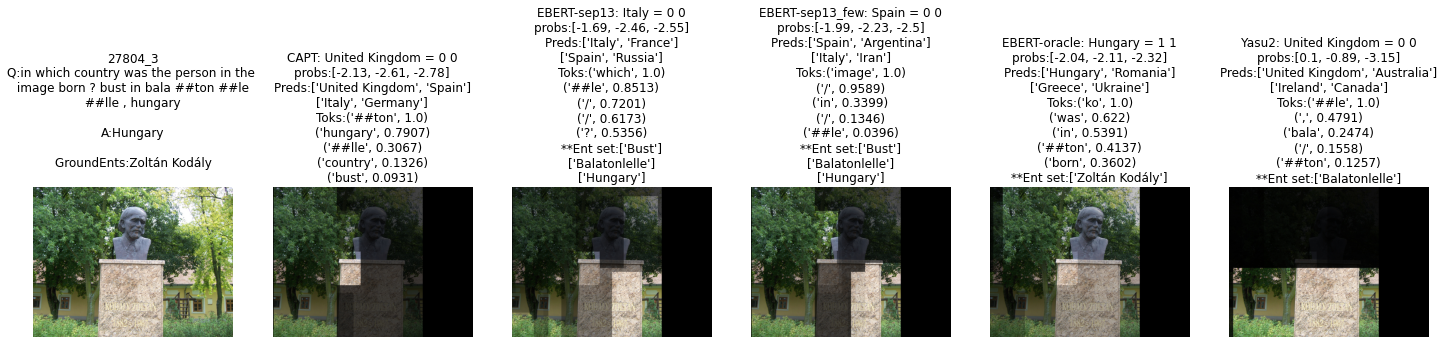

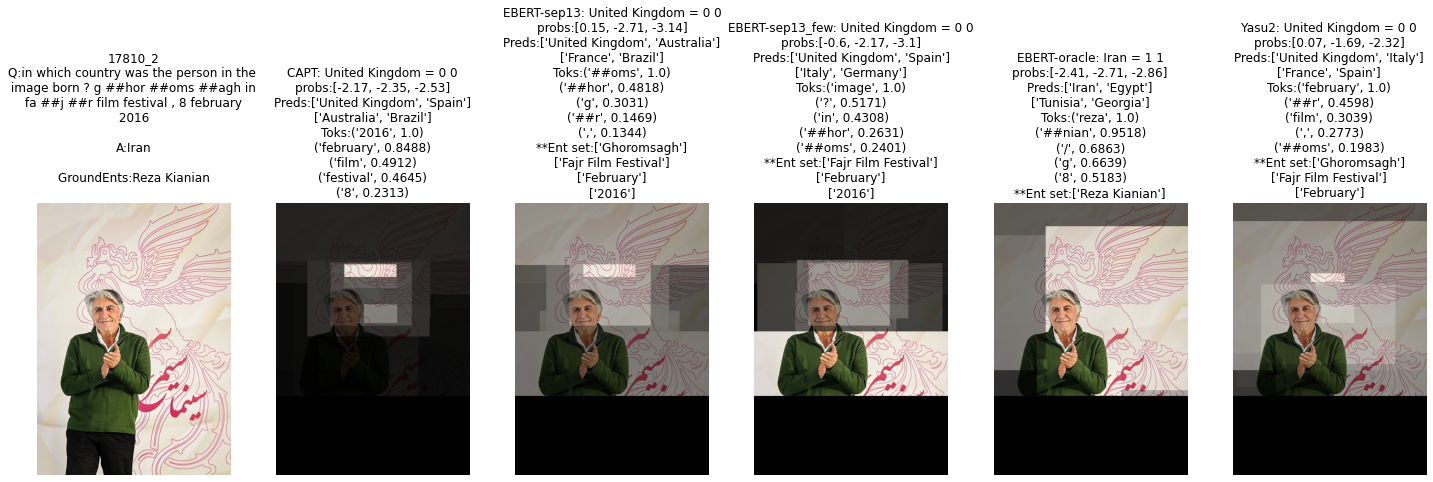

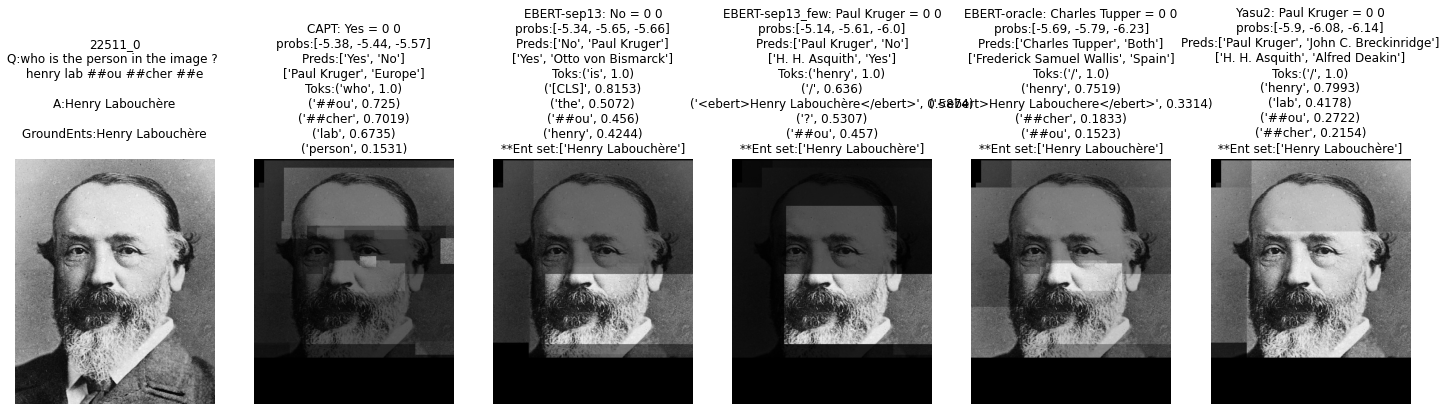

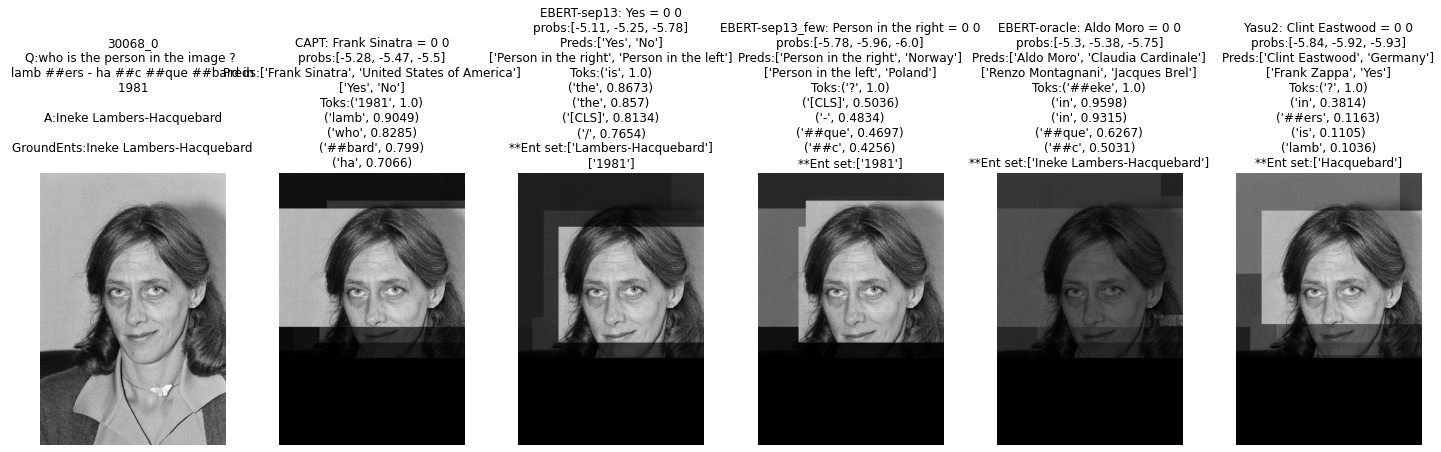

In [840]:
def show_very_unq_examples_for(nedf, mod_str="EBERT-oracle", thresh = .8, cmp="gte", to_show=2, show_qtypes = False):
    if cmp == "gte":
        oracle_unqs = nedf[(nedf.model == mod_str )& (nedf.top5_uniqueness >= thresh)]
    elif cmp == "gt":
        oracle_unqs = nedf[(nedf.model == mod_str )& (nedf.top5_uniqueness > thresh)]
    elif cmp == "lte":
        oracle_unqs = nedf[(nedf.model == mod_str )& (nedf.top5_uniqueness <= thresh)]
    elif cmp == "lt":
        oracle_unqs = nedf[(nedf.model == mod_str )& (nedf.top5_uniqueness < thresh)]
    else:
        oracle_unqs = nedf[(nedf.model == mod_str )& (nedf.top5_uniqueness == thresh)]
    
    print("For ",mod_str," with comp ",cmp,"and unq score threshhold ",thresh," we find ", oracle_unqs.shape[0], "examples with top1 mean of",oracle_unqs.top1acc.mean())     
    print("Collectively over all models these questions have a top1 mean of :", round(nedf[nedf.qid.isin(oracle_unqs.qid.values)].top1acc.mean(),4),
          " and a unq_score mean of ", round(nedf[nedf.qid.isin(oracle_unqs.qid.values)].top5_uniqueness.mean(),4))

    oqs = list(oracle_unqs[oracle_unqs.top1acc == 1].qid.values)   
    print("*** Looking only at ",to_show," from cases where top1 = 1:", len(oqs))                                 
    qtypes = {}
    for i, qid in enumerate(oqs):          
        if show_qtypes:
            curq = " ".join(oracle_unqs[oracle_unqs.qid == qid].tokens.values[0]).split("?")[0].split("[CLS]")[1]
            if curq not in qtypes:
                qtypes[curq] = 0
            qtypes[curq] +=1 
            
        if i < to_show:
            show_kvqa_bimodal_expls_img(qid, nedf, okfigsize=(25,5))
            
    if show_qtypes:
        for q in qtypes:
            if qtypes[q] > 1:
                print(q, qtypes[q])
    
    
    oqs = list(oracle_unqs[oracle_unqs.top1acc == 0].qid.values)   
    print("\n*** and then Looking only at ",to_show," from cases where top1 = 0:", len(oqs))                                 
    qtypesb = {}
    for i, qid in enumerate(oqs):         
        if show_qtypes:
            curq = " ".join(oracle_unqs[oracle_unqs.qid == qid].tokens.values[0]).split("?")[0].split("[CLS]")[1]
            if curq not in qtypesb:
                qtypesb[curq] = 0
            qtypesb[curq] +=1 
            
        if i < to_show:
            show_kvqa_bimodal_expls_img(qid, nedf, okfigsize=(25,5))  
    
    if show_qtypes:
        for q in qtypesb:
            if qtypesb[q] > 1:
                print(q, qtypesb[q])

"""
### HIGH SCORES
For  EBERT-oracle with comp  gte and unq score threshhold  0.8  we find  746 examples with top1 mean of 0.0509   ( 38 vs 708)
Collectively over all models these questions have a top1 mean of : 0.0275
 
For  Yasu2  with comp  gte and unq score threshhold  0.8  we find  299 examples with top1 mean of 0.0  (0 v 299 )
Collectively over all models these questions have a top1 mean of : 0.024 

For  EBERT-sep13_few  and unq score threshhold  0.8  we find  169 examples with top1 mean of 0.00591
Collectively over all models these questions have a top1 mean of : 0.0178
*** and then Looking only at  2  from cases where top1 = 0: 168
 who is the person in the image  71
 for how many years did the person in the image live  47   <--- interesting cause it doesn't happen in other models  ( 22587_1 )
 in which country was the person in the image born  14
 
 
### LOW SCORES
For  EBERT-oracle  with comp  eq and unq score threshhold  0  we find  8166 examples with top1 mean of 0.6276022532451628
Collectively over all models these questions have a top1 mean of : 0.6132 (5125 vs 3041 )

For  EBERT-oracle  with comp  lte and unq score threshhold  0.2  we find  14508 examples with top1 mean of 0.6158671078025917
Collectively over all models these questions have a top1 mean of : 0.5946 ( 8935 vs 5573 )


### THOUGHTS 
# SO EFFECTIVELY high UNIQ SCOREs ALLOWS US TO FIND HARD EXAMPLES  (looking at ones where 
# AND low UNIQ SCOREs allow us to find easy examples 

"""
#TODO: CAPT AND PLAIN FAIL CAUSE THEY'RE TOKENS AREN'T SAVED  ( at beginning when tokenizing save ) 
show_very_unq_examples_for(nedf, mod_str="EBERT-oracle", thresh = 1, cmp="eq", to_show=2)


## NEXT LOOK AT HOW ORACLE DID LAST NIGHT AND MOVE ON TO NEXT TODOS  <----


Looking at EBERT-oracle  predictions where <ebert> tag is most influential token for prediction
For  EBERT-oracle  and ebert influence of top k= 1  we find  45 examples with top1acc mean 0.5111
Collectively over all models these questions have a top1 mean of : 0.5852
*** cases where top1 = 1: 23
*** cases where top1 = 1 for  EBERT-oracle  and top1 = 0 for CaPT:  2
['43610_4', '26958_3']
*** cases where top1 = 0: 22
*** cases where top1 = 0 for  EBERT-oracle  and top1 = 1 for CaPT:  8


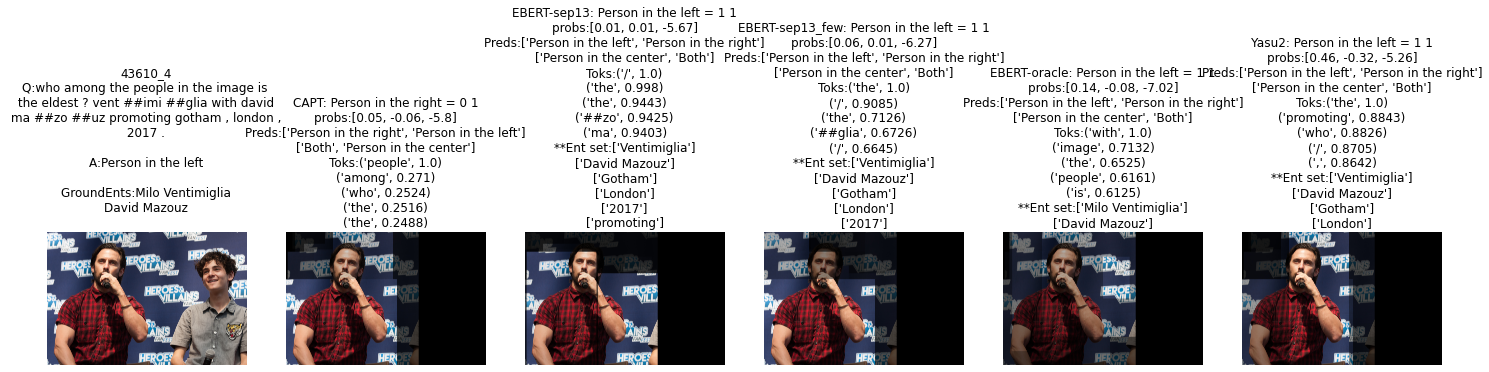

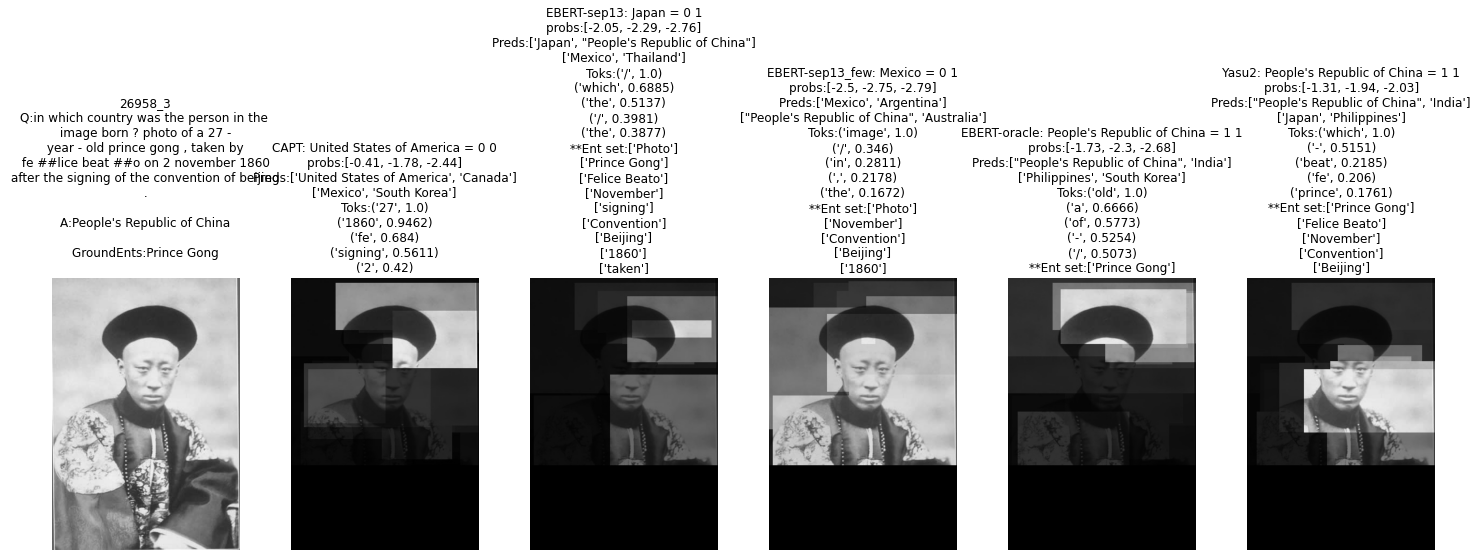

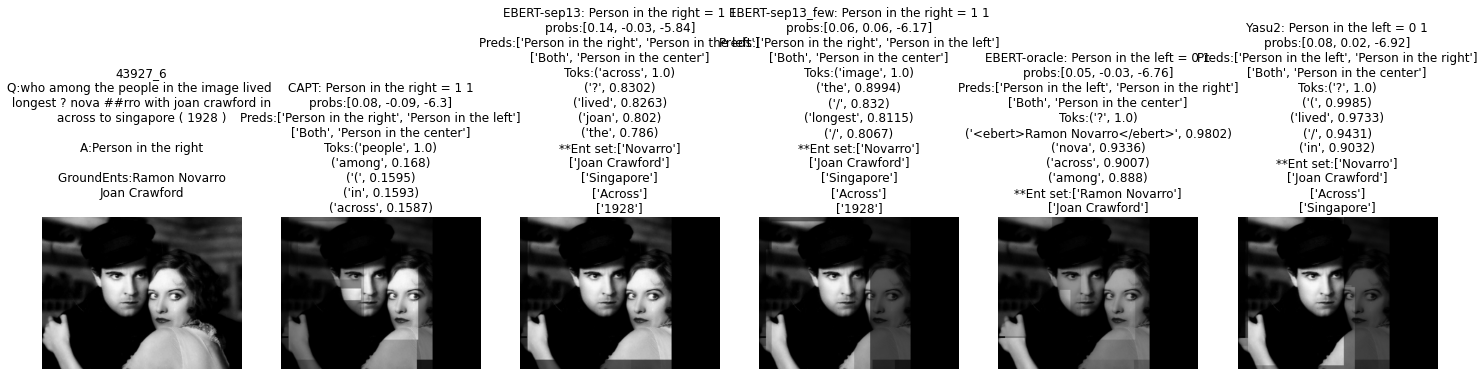

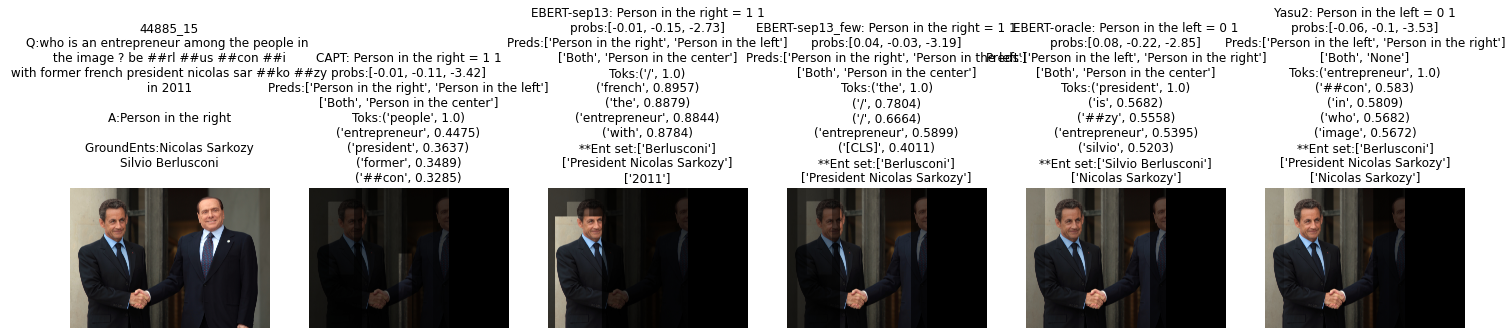

In [887]:
# 9/24

# 2. B find examples where EBERT is actually influential!    
#      what if i only trained on cases with EBERT and then used another model for non EBERT?
#       -- is it possible the model is learning to discard the ebert reps in most cases since its not prevelant quite a bit?
#            --> if possible, moreso likely with OKVQA since with KVQA we always have at least 90% of questions with ent sets

def show_influential_ebert_tags(nedf, mod_str="EBERT-oracle", k=1, to_show = 5):
    oracle_ones = get_topk_most_influential_examples(nedf, modstr = mod_str, k = k, to_show=0)
    # topfew = edf[(edf.model == modstr)& (edf.topent_imp != -1 ) & (edf.topent_imp < k)]

    print("For ",mod_str," and ebert influence of top k=",k," we find ", oracle_ones.shape[0], "examples with top1acc mean", round(oracle_ones.top1acc.mean(),4))     
    print("Collectively over all models these questions have a top1 mean of :", round(nedf[nedf.qid.isin(oracle_ones.qid.values)].top1acc.mean(),4),)

    oqs = list(oracle_ones[oracle_ones.top1acc == 1].qid.values)   
    print("*** cases where top1 = 1:", len(oqs))
            
    captwrong = nedf[(nedf.qid.isin(oqs))&(nedf.model == "CAPT")&(nedf.top1acc == 0)]
    oqs = list(captwrong.qid.values)
    print("*** cases where top1 = 1 for ",mod_str," and top1 = 0 for CaPT: ",len(oqs))

    if to_show != 0:
        print(oqs)
        
    # Show examples where it makes a difference for good
    for i, qid in enumerate(oqs):          
        if i < to_show or to_show == -1:
            try:
                show_kvqa_bimodal_expls_img(qid, nedf, okfigsize=(25,5))
            except Exception as e:
                print("Error ",e," ON qid:", qid)
          
        
    oqs = list(oracle_ones[oracle_ones.top1acc == 0].qid.values)   
    print("*** cases where top1 = 0:", len(oqs))
            
    captwrong = nedf[(nedf.qid.isin(oqs))&(nedf.model == "CAPT")&(nedf.top1acc == 1)]
    oqs = list(captwrong.qid.values)
    print("*** cases where top1 = 0 for ",mod_str," and top1 = 1 for CaPT: ",len(oqs))
    
    # Show examples where it makes a difference for bad
    for i, qid in enumerate(oqs):          
        if i < to_show or to_show == -1:
            try:
                show_kvqa_bimodal_expls_img(qid, nedf, okfigsize=(25,5))
            except Exception as e:
                print("Error ",e," ON qid:", qid)

                
"""
Looking at EBERT-oracle  predictions where <ebert> tag is most influential token for prediction
For  EBERT-oracle  and ebert influence of ** top k= 1 ** we find  45 examples with top1acc mean 0.5111
Collectively over all models these questions have a top1 mean of : 0.5852
*** cases where top1 = 1: 23
*** cases where top1 = 1 for  EBERT-oracle  and top1 = 0 for CaPT:  2
*** cases where top1 = 0: 22
*** cases where top1 = 0 for  EBERT-oracle  and top1 = 1 for CaPT:  8

For  EBERT-oracle  and ebert influence of ** top k= 3 **  we find  328 examples with top1acc mean 0.6037
Collectively over all models these questions have a top1 mean of : 0.625
*** cases where top1 = 1: 198
*** cases where top1 = 1 for  EBERT-oracle  and top1 = 0 for CaPT:  18
*** cases where top1 = 0: 130
*** cases where top1 = 0 for  EBERT-oracle  and top1 = 1 for CaPT:  37

For  EBERT-oracle  and ebert influence of ** top k= 5 ** we find  690 examples with top1acc mean 0.5783
Collectively over all models these questions have a top1 mean of : 0.5935
*** cases where top1 = 1: 399
*** cases where top1 = 1 for  EBERT-oracle  and top1 = 0 for CaPT:  58
*** cases where top1 = 0: 291
*** cases where top1 = 0 for  EBERT-oracle  and top1 = 1 for CaPT:  78
"""
                
show_influential_ebert_tags(nedf, mod_str="EBERT-oracle", k=1, to_show = 2)




# 3. Check attribution is correct.  
#   Make sure my assumption about starting / ending with [CLS] + [SEP]  is correct ( basically assert len(toks) == len(txt_exps ))
#   and make sure you join wordpieces before showing end results
    

In [635]:
#SCATCH

#x = set(res)
#print(x)

#'Mary of Hungary, Queen of Naples'

ent_title = 'mary of hungary, queen of naples'
print("Without surface2wiki Checking if ",ent_title," in self.wiki_emb")  
ent_title_orig = ent_title                        
if ent_title not in wiki_emb:
    print("1",ent_title)
    ent_title = ent_title.title()                 
    if ent_title not in wiki_emb:            
        print("2", ent_title)
        ent_title = ent_title_orig.capitalize()   
        if ent_title not in wiki_emb and ent_title_orig.endswith("s") and ent_title_orig[0:-1].title() in wiki_emb:                                      
            print("3")
            ent_title = ent_title_orig[0:-1].title()       
ent_title  # so actually this mean it was not found in WikiEmb .. there is a web page however with it

#So this means there is still a god damn bug in the entity injection!!


Without surface2wiki Checking if  mary of hungary, queen of naples  in self.wiki_emb
1 mary of hungary, queen of naples
2 Mary Of Hungary, Queen Of Naples


'Mary of hungary, queen of naples'

In [401]:
#SCRATCH
"""
ent_title = 'hartmut nassauer'
print(ent_title.title(), ent_title.title() in wiki_emb)
print(ent_title.capitalize(), ent_title.capitalize() in wiki_emb)
print(ent_title.title().replace(" ","_"), ent_title.title().replace(" ","_") in wiki_emb)

import torch
x = torch.tensor([  101,  2040,  2003,  1996,  100,2711, 100, 1999,  1996,  3746,  1029,   100, 7530, 28120, 14646,  2121,   100,  1012,   102])

def remove_unks(x, debug=False):
    newx = x
    if debug:
        print("remove UNKS (100) from ", x)
    while 100 in newx:
        unklocs = [i for i in range(x.size(0)) if x[i] == 100 ]
        unkslen = len(unklocs)
        if debug:
            print("UNKS AT", unklocs, "handling first 2 of", unkslen)
        newx = torch.cat((x[0:unklocs[0]], x[(unklocs[0]+1):unklocs[1]], x[(unklocs[1]+1):]), axis=0)
        x = newx
        if debug:
            print("POST", newx, 100 in newx)
    return x
    
z = remove_unks(x,debug=True)

#x.resize_as(z)

f = x.unsqueeze(0)
print(f.size(), f[0].size(0), z.size(0), f[0].size(0) - z.size(0))
# here, pad = (padding_left, padding_right, padding_top, padding_bottom)
#source_pad = F.pad(source, pad=(0, 0, 0, 70 - source.shape[0]))
xz = torch.nn.functional.pad(z, pad=(0,f[0].size(0) - z.size(0)))
print(xz.size())
f[0] = xz




x = ['[CLS]', 'who', 'is', 'the', 'person', 'in', 'the', 'image', '?', '[UNK]', 'hart', '##mut', 'nassau', '##er', '[UNK]', '.', '[SEP]']
new_x = [ a for a in x if a != '[UNK]']

import unicodedata
from unidecode import unidecode
a = 'Henry Labouchère'
b = 'Henry Labouchere'

a == b  #False
unicodedata.normalize('NFD',a)== unicodedata.normalize('NFD',b) #False
unidecode(a) == unidecode(b)  #True

t='Late 19th century model for a statue of Engelbrekt Engelbrektsson to be placed in Örebro'
'Engelbrekt Engelbrektsson' in t  #True
"""
print()